# エンエージェント配布～入社決定データ分析

## 目的
- CPごとの得意な領域（求職者特徴）を明らかにする。
- 求職者特徴別の入社決定率リフトを計算し、最も入社決定数が伸びると期待される配布ルールを決定する。

## 分析内容
- CPごとに面談担当した求職者のエントリー～入社決定実績のをまとめたデータフレームを作成
- エントリー数が入社決定率に相関することを利用し、同一担当CPの中で属性間でエントリー数に差が表れる場合を”CPの強み”として定義する。
- 強みとして特定された属性を対象に、該当属性を強みにもつCPとそうでないCPがその特徴をもった会員をサポートした場合とそうでない場合でどれだけ入社決定しやすくなるかを計算し、リフト効果が最大の属性を特定する。


## ライブラリのインストール

In [1]:
import pandas as pd
import numpy as np

In [ ]:
# Refactored pipeline: import helper modules and run a compact preprocessing + feature pipeline.
from scripts.preprocessing import preprocess_merge, add_time_deltas, finalize_dataset
from scripts.feature_engineering import create_features
from scripts.u_test import run_mannwhitney_tests
from scripts.model import prepare_lgb_data, train_lgb_cv
from scripts.optuna_utils import optuna_search

# NOTE: this cell assumes the data-loading cell that reads the Excel file has been run
# and that df_mendan, df_oubo, df_seiyaku are present in the notebook namespace.
try:
    df_mendan
except NameError:
    print('Please run the data-loading cell to create df_mendan, df_oubo, df_seiyaku before executing this cell')

# Run preprocessing and feature engineering (will mirror the notebook logic)
df_merge_diff = preprocess_merge(df_mendan, df_oubo)
df_merge_diff = add_time_deltas(df_merge_diff, df_mendan, df_oubo)
df_merge_diff = create_features(df_merge_diff)
df_final = finalize_dataset(df_merge_diff, df_mendan, df_oubo, df_seiyaku)

print('Preprocessing + feature engineering completed via scripts. df_final is available.')
display(df_final.head())

In [2]:
!apt-get -y install fonts-ipafont-gothic
!pip install japanize-matplotlib
import japanize_matplotlib
import matplotlib.pyplot as plt

# 場合によっては必要
plt.rcParams['font.family'] = 'IPAPGothic'
japanize_matplotlib.japanize()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 2 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-mincho all 00303-21ubuntu1 [4,724 kB]
Fetched 8,237 kB in 2s (4,113 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-21ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-21ubuntu1) ...
Selecting previously unselected package fonts-ipaf

## データの取得

In [3]:
file = '/content/drive/MyDrive/Colab Notebooks/エンエージェントデータまとめ.xlsx'
df_mendan = pd.read_excel(file, sheet_name='面談')
df_oubo = pd.read_excel(file, sheet_name='応募')
df_seiyaku = pd.read_excel(file, sheet_name='成約')

In [4]:
df_mendan.head()

求職者ID    エンエージェントジャッジ          登録経路 人材ランク                面談日時   面談形式  \
0  2488296  enエージェントジャッジNG    AMBI（案件応募）     C 2025-01-06 10:00:00  WEB面談   
1  6394529  enエージェントジャッジNG  ミドルの転職（案件応募）     C 2025-01-06 10:00:00   電話面談   
2  6609768  enエージェントジャッジNG  ミドルの転職（案件応募）     A 2025-01-06 10:00:00   電話面談   
3  2413888  enエージェントジャッジNG  ミドルの転職（案件応募）     A 2025-01-06 10:00:00   電話面談   
4  6611478  enエージェントジャッジNG    エン転職（スカウト）     B 2025-01-06 10:00:00   電話面談   

    面談者   人材担当の所属Div 人材担当の所属チーム  人材担当  ...     登録経路.1   ★登録経路 面談カウント対象  \
0  雑賀千紘  首都圏CP第5グループ      布田チーム  雑賀千紘  ...    03.AMBI    AMBI       対象   
1  世川実栞  ミドルエージェント直下         直下    石川  ...  02.ミドルの転職  ミドルの転職       対象   
2  田巻祐子  ミドルエージェント直下         直下    石川  ...  02.ミドルの転職  ミドルの転職       対象   
3  土田涼夏  ミドルエージェント直下         直下    石川  ...  02.ミドルの転職  ミドルの転職       対象   
4  岩崎華子      RPOグループ      野木チーム  岩崎華子  ...    01.エン転職    エン転職       対象   

           ★経験職種               職種区分（大）  面談フラグ      面談所属判別用          面談所属div  \
0        広告宣伝、PR  02.企画・事務・マーケティング・管理系      1  202501_雑賀千紘      首都圏CP第5グループ   
1       人事、労務、採用  02.企画・事務・マーケティング・管理系      1  202501_世川実栞    管理部門（久保田）グループ   
2  営業マネージャー・営業管理                01.営業系      1  202501_田巻祐子  インダストリー（伊藤）グループ   
3           法人営業                01.営業系      1  202501_土田涼夏  インダストリー（伊藤）グループ   
4           法人営業                01.営業系      1  202501_岩崎華子          RPOグループ   

   面談所属T     面談予実用登録経路  
0  布田チーム    AMBI（広告掲載）  
1  内山チーム  ミドルの転職（広告掲載）  
2  田巻チーム  ミドルの転職（広告掲載）  
3  山崎チーム  ミドルの転職（広告掲載）  
4  野木チーム    エン転職（スカウト）  

[5 rows x 35 columns]

In [5]:
df_oubo.head()

進捗ID   担当ECの所属部署 担当ECの所属チーム   担当EC 担当CPの所属部署 担当CPの所属チーム    担当CP 案件ランク  \
0   97757693      関西グループ      赤井チーム  赤井 大地    関西グループ      芹生チーム  芹生 恵美里     B   
1  139220036      経理グループ      山崎チーム   山崎 凌    直下グループ        営業外     石川      A   
2  142894684    IT第1グループ      松原チーム  藤田 基希    関西グループ      石戸チーム   中島 啓輔     B   
3  142894685    IT第1グループ      松原チーム  藤田 基希    関西グループ      石戸チーム   中島 啓輔     B   
4  160135960  メーカー第2グループ   佐藤（愛）チーム   川合 悠  管理部門グループ   高山（瑞）チーム   高山 瑞生     A   

  人材ランク            応募経路  ... 求職者現在年収（単位：万円）  \
0     C  エージェントタブ（エン転職）  ...          450.0   
1     C        マイページアプリ  ...          750.0   
2     B         enFIT経由  ...          975.0   
3     B         enFIT経由  ...          975.0   
4     A  エージェントタブ（エン転職）  ...          325.0   

                                              過去経験職種          コア経験職種   応募承諾月  \
0                                 ビルメンテナンス、ビル設備管理技能士     設備保全・メンテナンス  202507   
1  経理、経理事務,その他サービスエンジニア,事業企画、新規事業、事業開発,経営企画,内部監査、...         経理、経理事務  202507   
2  社内システム開発・運用,プロジェクトマネージャー（Web・アプリ・オープン系）,エンジニア（...  パッケージ導入コンサルタント  202507   
3  社内システム開発・運用,プロジェクトマネージャー（Web・アプリ・オープン系）,エンジニア（...  パッケージ導入コンサルタント  202507   
4      その他販売・サービス系,販売・接客スタッフ、売り場担当（その他流通・小売）,経理、経理事務         経理、経理事務  202507   

       応募承諾週 求職者年齢       年齢帯    求職者年収帯  求職者登録経路.1   ★登録経路  
0 2025-06-30    32    03.30代   03.400台    01.エン転職    エン転職  
1 2025-06-30    58  05.50代以上  05.600以上    01.エン転職    エン転職  
2 2025-06-30    56  05.50代以上  05.600以上  02.ミドルの転職  ミドルの転職  
3 2025-06-30    56  05.50代以上  05.600以上  02.ミドルの転職  ミドルの転職  
4 2025-06-30    35    03.30代   02.300台    01.エン転職    エン転職  

[5 rows x 39 columns]

In [6]:
df_seiyaku.head()

BID    求職者ID    人材ランク     企業ID          社名    求人ID  \
0    54352   516698        C    18297    株式会社ナンシン  177137   
1    31849  2831154        B    18251     株式会社VSN  150286   
2  2757076  2939000        A  1837789      信金中央金庫  170292   
3    21135  2692062        A    16596   ナミキ商事株式会社  157395   
4  1105333  2590704  （データなし）  1007896  東京燃料林産株式会社  181570   

                                   ポジション名 求人ランク       CPグループ         CPチーム  \
0                   総務・人事 ～JASDAQ上場の優良企業～     A  首都圏CP第2グループ         第2チーム   
1       システムエンジニア ★上流工程へのキャリアパスあり！教育体制充実★     B  首都圏EC第1グループ  ITエンジニアCPチーム   
2              総合職 / 信用金庫の中央機関 /月残業20時間以下     B  首都圏CP第3グループ         第1チーム   
3  海外サプライヤーからの仕入れ担当　 ※語学力を活かした業務/残業20時間程度     A  首都圏CP第3グループ         第2チーム   
4       事務職　～未経験歓迎～ ※幅広いバックオフィス業務をお任せします！     A  首都圏CP第1グループ         第4チーム   

   ...               データ登録日                       成約先業種  \
0  ...  2016-03-11 12:19:55    重電・産業用電気機器,機械関連,自動車・輸送機器   
1  ...  2018-12-20 22:47:57                   人材派遣・人材紹介   
2  ...  2019-02-04 02:14:36              信用組合・信用金庫・労働金庫   
3  ...  2018-11-01 07:36:22  化学・石油・ガラス・セラミック・セメント,鉄鋼・金属   
4  ...  2018-09-18 22:58:46                        専門商社   

               成約職種大カテゴリ                                               成約職種  \
0              企画・事務・管理系                                        総務,人事、労務、採用   
1  エンジニア系（IT・Web・ゲーム・通信）  エンジニア（Web・アプリ・オープン系）,プログラマ（Web・アプリ・オープン系）,プロジェ...   
2   専門職系（コンサルタント、金融、不動産）  その他金融系専門職,法人営業,事業企画、新規事業、事業開発,営業企画、販促企画,金融事務、金融管理   
3              企画・事務・管理系                      購買・資材調達,通訳、翻訳,貿易事務、通関士、国際関連業務   
4              企画・事務・管理系             経理、経理事務,人事、労務、採用,総務,一般事務,営業事務・営業アシスタント   

  求人年収下限  求人年収上限 学歴判定  学歴区分   学歴最終   エン エージェントジャッジ  
0    300     450    0  大卒以上  大卒一般校  enエージェントジャッジNG  
1    350     550    0  大卒以上  大卒一般校  enエージェントジャッジOK  
2    500     700    0  大卒以上  大卒一般校  enエージェントジャッジOK  
3    374     450    0  大卒以上  大卒一般校  enエージェントジャッジOK  
4    300     350    0  大卒以上  大卒一般校  enエージェントジャッジNG  

[5 rows x 48 columns]

In [7]:
print("df_mendanの形状:", df_mendan.shape)
print("df_ouboの形状:", df_oubo.shape)
print("df_seiyakuの形状:", df_seiyaku.shape)

df_mendanの形状: (45480, 35)
df_ouboの形状: (198757, 39)
df_seiyakuの形状: (8969, 48)


## データの前処理

必要なデータのジョイン

In [8]:
excluded_mendan_cols = [
    '人材担当',
    '求職者生年月日', # Corrected from '生年月日' to match actual column name in df_mendan
   # 'データ登録日', # Added as it was requested but not excluded previously
    '面談日時', # Closest match for '面談日', also explicitly requested
    '面談月', # Added as it was requested but not excluded previously
    '面談週', # Added as it was requested but not excluded previously
    '年齢帯',
    '★登録経路',
    '面談カウント対象',
    '★経験職種',
    '面談フラグ',
    '面談所属判別用',
    '面談所属div',
    '面談所属T',
    '面談予実用登録経路',
    '26期首都圏',
    '首都圏配布',
    '暫定用組織',
    '★キックオフ用領域'
]

# Get columns to keep from df_mendan
mendan_cols_to_keep = [col for col in df_mendan.columns if col not in excluded_mendan_cols or col == '求職者ID']

# Select only the relevant columns from df_mendan for merging
df_mendan_filtered = df_mendan[mendan_cols_to_keep].copy()

# Perform the left join
df_merged = pd.merge(df_oubo, df_mendan_filtered, on='求職者ID', how='left')

print("Merged DataFrame created successfully.")
print("Shape of the merged DataFrame:", df_merged.shape)
display(df_merged.head())

Merged DataFrame created successfully.
Shape of the merged DataFrame: (235886, 60)


進捗ID   担当ECの所属部署 担当ECの所属チーム   担当EC 担当CPの所属部署 担当CPの所属チーム    担当CP 案件ランク  \
0   97757693      関西グループ      赤井チーム  赤井 大地    関西グループ      芹生チーム  芹生 恵美里     B   
1  139220036      経理グループ      山崎チーム   山崎 凌    直下グループ        営業外     石川      A   
2  142894684    IT第1グループ      松原チーム  藤田 基希    関西グループ      石戸チーム   中島 啓輔     B   
3  142894685    IT第1グループ      松原チーム  藤田 基希    関西グループ      石戸チーム   中島 啓輔     B   
4  160135960  メーカー第2グループ   佐藤（愛）チーム   川合 悠  管理部門グループ   高山（瑞）チーム   高山 瑞生     A   

  人材ランク_x            応募経路  ...  転職回数 現在年収（単位：万円）              データ登録日 転職の温度感  \
0       C  エージェントタブ（エン転職）  ...   1.0       450.0 2019-05-28 17:56:43    茨城県   
1       C        マイページアプリ  ...  10.0       750.0 2013-11-12 10:19:47   神奈川県   
2       B         enFIT経由  ...   NaN         NaN                 NaT    NaN   
3       B         enFIT経由  ...   NaN         NaN                 NaT    NaN   
4       A  エージェントタブ（エン転職）  ...   NaN         NaN                 NaT    NaN   

     希望転職時期        面談日    年齢       年収帯   登録経路.1               職種区分（大）  
0  良いところあれば 2025-07-01  32.0   03.400台  01.エン転職         09.技術系（建築、土木）  
1      意思固い 2025-04-14  58.0  05.600以上  01.エン転職  02.企画・事務・マーケティング・管理系  
2       NaN        NaT   NaN       NaN      NaN                   NaN  
3       NaN        NaT   NaN       NaN      NaN                   NaN  
4       NaN        NaT   NaN       NaN      NaN                   NaN  

[5 rows x 60 columns]

Nan・重複・使用しないカラムの除去

In [9]:
# 使用しないカラムの除去
columns_to_drop = [
    '求職者登録経路',
    #'求職者面談日時',
    '求職者生年月日',
    #'応募承諾日',
    #'応募承諾週',
    '年齢帯',
    '生年月日',
    '求職者年収帯',
    '★登録経路',
    '登録経路.1', # This column seems to be the one referred to as '求職者登録経路' in the list of unnecessary columns based on previous output. I'll drop both '求職者登録経路' and '登録経路.1'.
    '6/16追加（土日祝日集計漏れ分）'
    '「1次面接設定中」のステータス登録日',
    #'１次面接日',
    '最終面接日',
    '本人意思確認待ちステータス日付',
    '入社実績入力待ちステータス日付',
    '求職者登録経路.1',
    'エンエージェントジャッジ',
    '人材ランク_y',
    #'データ登録日',
    #'面談月',
    '面談週',
    'EC書類提出日',
    #'企業書類提出日',
    'コア経験職種_y',
    '進捗ID',
    '担当ECの所属部署',
    '担当ECの所属チーム',
    '担当EC',
    '担当CPの所属部署',
    '担当CPの所属チーム',
    '「1次面接設定中」のステータス登録日',
     '面談者',
     '人材担当の所属Div',
    '人材担当の所属チーム',
    '企業ID',
    '過去経験職種',
    '求職者現在年収（単位：万円）',
    #'応募承諾月',
    '面談日'
]

# Drop columns if they exist in df_merged
df_merged = df_merged.drop(columns=[col for col in columns_to_drop if col in df_merged.columns])

print("Unnecessary columns removed successfully.")
print("New shape of the merged DataFrame:", df_merged.shape)
display(df_merged.head())

Unnecessary columns removed successfully.
New shape of the merged DataFrame: (235886, 31)


担当CP 案件ランク 人材ランク_x            応募経路   紹介経路    企業書類提出日 １次面接日    求人ID  \
0  芹生 恵美里     B       C  エージェントタブ（エン転職）  経験マッチ        NaT   NaT  370803   
1     石川      A       C        マイページアプリ   CP厳選 2025-07-01   NaT  440565   
2   中島 啓輔     B       B         enFIT経由   CP厳選        NaT   NaT  431100   
3   中島 啓輔     B       B         enFIT経由   CP厳選        NaT   NaT  431062   
4   高山 瑞生     A       A  エージェントタブ（エン転職）   CP厳選        NaT   NaT  503074   

                 企業                業種  ...  学歴区分  \
0      フクシマガリレイ株式会社    メーカー（機械・電気・電子）  ...  大卒以上   
1         株式会社神戸製鋼所  メーカー（素材・食品・医薬品他)  ...  大卒以上   
2           株式会社クラレ  メーカー（素材・食品・医薬品他)  ...   NaN   
3           株式会社クラレ  メーカー（素材・食品・医薬品他)  ...   NaN   
4  弁護士法人ベリーベスト法律事務所     コンサルティング, その他  ...   NaN   

                                                経験業種  転職回数  現在年収（単位：万円）  \
0                                              建設・土木   1.0        450.0   
1  コンピュータ・通信機器・OA機器関連,半導体・電子・電気部品,化学・石油・ガラス・セラミック...  10.0        750.0   
2                                                NaN   NaN          NaN   
3                                                NaN   NaN          NaN   
4                                                NaN   NaN          NaN   

               データ登録日 転職の温度感    希望転職時期    年齢       年収帯               職種区分（大）  
0 2019-05-28 17:56:43    茨城県  良いところあれば  32.0   03.400台         09.技術系（建築、土木）  
1 2013-11-12 10:19:47   神奈川県      意思固い  58.0  05.600以上  02.企画・事務・マーケティング・管理系  
2                 NaT    NaN       NaN   NaN       NaN                   NaN  
3                 NaT    NaN       NaN   NaN       NaN                   NaN  
4                 NaT    NaN       NaN   NaN       NaN                   NaN  

[5 rows x 31 columns]

In [10]:
df_merged.rename(columns={
    '希望転職時期': '転職温度感',
    '転職の温度感': '現在住所',
    '現在年収（単位：万円）':'現在年収',
    '職種カテゴリー':'職種',
}, inplace=True)

print("Columns renamed successfully.")
display(df_merged.head())

Columns renamed successfully.


担当CP 案件ランク 人材ランク_x            応募経路   紹介経路    企業書類提出日 １次面接日    求人ID  \
0  芹生 恵美里     B       C  エージェントタブ（エン転職）  経験マッチ        NaT   NaT  370803   
1     石川      A       C        マイページアプリ   CP厳選 2025-07-01   NaT  440565   
2   中島 啓輔     B       B         enFIT経由   CP厳選        NaT   NaT  431100   
3   中島 啓輔     B       B         enFIT経由   CP厳選        NaT   NaT  431062   
4   高山 瑞生     A       A  エージェントタブ（エン転職）   CP厳選        NaT   NaT  503074   

                 企業                業種  ...  学歴区分  \
0      フクシマガリレイ株式会社    メーカー（機械・電気・電子）  ...  大卒以上   
1         株式会社神戸製鋼所  メーカー（素材・食品・医薬品他)  ...  大卒以上   
2           株式会社クラレ  メーカー（素材・食品・医薬品他)  ...   NaN   
3           株式会社クラレ  メーカー（素材・食品・医薬品他)  ...   NaN   
4  弁護士法人ベリーベスト法律事務所     コンサルティング, その他  ...   NaN   

                                                経験業種  転職回数   現在年収  \
0                                              建設・土木   1.0  450.0   
1  コンピュータ・通信機器・OA機器関連,半導体・電子・電気部品,化学・石油・ガラス・セラミック...  10.0  750.0   
2                                                NaN   NaN    NaN   
3                                                NaN   NaN    NaN   
4                                                NaN   NaN    NaN   

               データ登録日  現在住所     転職温度感    年齢       年収帯               職種区分（大）  
0 2019-05-28 17:56:43   茨城県  良いところあれば  32.0   03.400台         09.技術系（建築、土木）  
1 2013-11-12 10:19:47  神奈川県      意思固い  58.0  05.600以上  02.企画・事務・マーケティング・管理系  
2                 NaT   NaN       NaN   NaN       NaN                   NaN  
3                 NaT   NaN       NaN   NaN       NaN                   NaN  
4                 NaT   NaN       NaN   NaN       NaN                   NaN  

[5 rows x 31 columns]

In [11]:
print(df_merged.columns)

Index(['担当CP', '案件ランク', '人材ランク_x', '応募経路', '紹介経路', '企業書類提出日', '１次面接日', '求人ID',
       '企業', '業種', '職種', '求人年収下限（単位：万円）', '求人年収上限（単位：万円）', '求職者ID', '求職者面談日時',
       'コア経験職種_x', '応募承諾月', '応募承諾週', '求職者年齢', '登録経路', '面談形式', '学歴区分', '経験業種',
       '転職回数', '現在年収', 'データ登録日', '現在住所', '転職温度感', '年齢', '年収帯', '職種区分（大）'],
      dtype='object')


In [12]:
# 欠損値を除外しないカラムのリスト
columns_to_exclude_from_dropna = [
    '企業書類提出日', '１次面接日', '求職者面談日時',
    '求人年収下限（単位：万円）', '求人年収上限（単位：万円）',
    '応募承諾月', '応募承諾週', 'データ登録日'
]

# 欠損値を含む行を削除する対象カラムのリストを作成
# df_merged の全カラムから除外カラムを除いたもの
columns_for_dropna_subset = [col for col in df_merged.columns
                             if col not in columns_to_exclude_from_dropna]

# 指定されたカラム以外の欠損値を含む行を削除
df_merge_diff = df_merged.dropna(subset=columns_for_dropna_subset).copy()

print("Rows with NaN values (excluding specified columns) removed successfully.")
print("New shape of df_merge_diff:", df_merge_diff.shape)
display(df_merge_diff.head())

Rows with NaN values (excluding specified columns) removed successfully.
New shape of df_merge_diff: (192024, 31)


担当CP 案件ランク 人材ランク_x            応募経路   紹介経路    企業書類提出日 １次面接日    求人ID  \
0  芹生 恵美里     B       C  エージェントタブ（エン転職）  経験マッチ        NaT   NaT  370803   
1     石川      A       C        マイページアプリ   CP厳選 2025-07-01   NaT  440565   
5   谷本 若菜     B       A      Webマイページ経由   CP厳選        NaT   NaT  512097   
6   下田 朝陽     A       C         enFIT経由  経験マッチ        NaT   NaT  516121   
7    永島 快     B       C         enFIT経由  経験マッチ 2025-07-01   NaT  515703   

                     企業                業種  ...  学歴区分  \
0          フクシマガリレイ株式会社    メーカー（機械・電気・電子）  ...  大卒以上   
1             株式会社神戸製鋼所  メーカー（素材・食品・医薬品他)  ...  大卒以上   
5             パーク２４株式会社              サービス  ...  大卒以上   
6       株式会社KPIソリューションズ     IT・通信・インターネット  ...  大卒以上   
7  株式会社アムコー・テクノロジー・ジャパン    メーカー（機械・電気・電子）  ...    高卒   

                                                経験業種  転職回数   現在年収  \
0                                              建設・土木   1.0  450.0   
1  コンピュータ・通信機器・OA機器関連,半導体・電子・電気部品,化学・石油・ガラス・セラミック...  10.0  750.0   
5                              ソフトウェア・情報処理,人材派遣・人材紹介   1.0  375.0   
6                                  団体・連合会・官公庁・独立行政法人   2.0  720.0   
7                半導体・電子・電気部品,家電・AV機器・ゲーム機器,精密機器・計測機器   2.0  450.0   

               データ登録日  現在住所     転職温度感    年齢       年収帯               職種区分（大）  
0 2019-05-28 17:56:43   茨城県  良いところあれば  32.0   03.400台         09.技術系（建築、土木）  
1 2013-11-12 10:19:47  神奈川県      意思固い  58.0  05.600以上  02.企画・事務・マーケティング・管理系  
5 2018-07-07 04:03:09   東京都  良いところあれば  32.0   02.300台           06.クリエイティブ系  
6 2024-12-18 14:43:30   東京都  良いところあれば  34.0  05.600以上  02.企画・事務・マーケティング・管理系  
7 2018-07-21 11:02:03   長崎県  良いところあれば  36.0   03.400台      08.技術系（電気、電子、機械）  

[5 rows x 31 columns]

In [13]:
print("NaN values in df_ml:")
print(df_merge_diff.isnull().sum())

NaN values in df_ml:
担当CP                  0
案件ランク                 0
人材ランク_x               0
応募経路                  0
紹介経路                  0
企業書類提出日          137127
１次面接日            191773
求人ID                  0
企業                    0
業種                    0
職種                    0
求人年収下限（単位：万円）         6
求人年収上限（単位：万円）       185
求職者ID                 0
求職者面談日時               0
コア経験職種_x              0
応募承諾月                 0
応募承諾週                 0
求職者年齢                 0
登録経路                  0
面談形式                  0
学歴区分                  0
経験業種                  0
転職回数                  0
現在年収                  0
データ登録日                0
現在住所                  0
転職温度感                 0
年齢                    0
年収帯                   0
職種区分（大）               0
dtype: int64


In [14]:
df_merge_diff.describe()

企業書類提出日                          １次面接日  \
count                          54897                            251   
mean   2025-09-26 19:38:14.486036992  2025-09-23 10:31:04.541832704   
min              2025-06-09 00:00:00            2025-05-01 00:00:00   
25%              2025-08-13 00:00:00            2025-08-13 12:00:00   
50%              2025-09-24 00:00:00            2025-09-25 00:00:00   
75%              2025-11-12 00:00:00            2025-10-30 12:00:00   
max              2026-01-07 00:00:00            2026-01-08 00:00:00   
std                              NaN                            NaN   

                求人ID  求人年収下限（単位：万円）  求人年収上限（単位：万円）         求職者ID  \
count  192024.000000  192018.000000  191839.000000  1.920240e+05   
mean   590205.839530     582.968003     844.393669  4.611443e+06   
min     16737.000000       1.000000       2.000000  4.810400e+04   
25%    576177.000000     450.000000     610.000000  2.555252e+06   
50%    596610.000000     588.000000     800.000000  5.701620e+06   
75%    617388.000000     680.000000    1000.000000  6.752058e+06   
max    652593.000000    2000.000000   10000.000000  6.916648e+06   
std     42396.851808     179.807675     309.494778  2.354235e+06   

               応募承諾月                          応募承諾週          求職者年齢  \
count  192024.000000                         192024  192024.000000   
mean   202511.123766  2025-09-25 14:21:12.440945408      39.919437   
min    202507.000000            2025-06-30 00:00:00      18.000000   
25%    202508.000000            2025-08-11 00:00:00      31.000000   
50%    202509.000000            2025-09-22 00:00:00      39.000000   
75%    202511.000000            2025-11-10 00:00:00      49.000000   
max    202601.000000            2026-01-05 00:00:00      76.000000   
std        12.735432                            NaN      10.020438   

                転職回数          現在年収                         データ登録日  \
count  192024.000000  1.920240e+05                         192024   
mean        2.232200  1.127982e+03  2021-11-08 06:10:07.201870848   
min         0.000000  0.000000e+00            2012-09-04 00:00:00   
25%         1.000000  4.250000e+02            2018-09-03 10:19:26   
50%         2.000000  5.500000e+02            2022-12-13 22:36:17   
75%         3.000000  7.300000e+02            2025-06-15 00:33:11   
max        99.000000  1.200130e+07            2025-12-17 12:45:24   
std         1.995849  7.277034e+04                            NaN   

                  年齢  
count  192024.000000  
mean       39.776570  
min        18.000000  
25%        31.000000  
50%        39.000000  
75%        49.000000  
max        76.000000  
std         9.976544

## 特徴量エンジニアリング



1.   転職回数➡転職経験有無（0or1回以上）
2.   現在年収➡年収との差（上限年収-現在年収）
3.   求職者一人あたりエントリー数
4.   求職者別エントリー先業界の多様性(一致率)
5.   登録経路➡HP enfit or 社内サイト or 外部
6.   人材ランクと案件ランクの差➡ABCD…4321に変換
7.   データ登録～entry～入社までの経過時間




In [15]:
df_merge_diff['転職経験'] = df_merge_diff['転職回数'].apply(lambda x: '転職なし' if x == 0 else ('転職1回以上' if x >= 1 else x))

print("転職経験 column labeled successfully.")
display(df_merge_diff.head())

転職経験 column labeled successfully.


担当CP 案件ランク 人材ランク_x            応募経路   紹介経路    企業書類提出日 １次面接日    求人ID  \
0  芹生 恵美里     B       C  エージェントタブ（エン転職）  経験マッチ        NaT   NaT  370803   
1     石川      A       C        マイページアプリ   CP厳選 2025-07-01   NaT  440565   
5   谷本 若菜     B       A      Webマイページ経由   CP厳選        NaT   NaT  512097   
6   下田 朝陽     A       C         enFIT経由  経験マッチ        NaT   NaT  516121   
7    永島 快     B       C         enFIT経由  経験マッチ 2025-07-01   NaT  515703   

                     企業                業種  ...  \
0          フクシマガリレイ株式会社    メーカー（機械・電気・電子）  ...   
1             株式会社神戸製鋼所  メーカー（素材・食品・医薬品他)  ...   
5             パーク２４株式会社              サービス  ...   
6       株式会社KPIソリューションズ     IT・通信・インターネット  ...   
7  株式会社アムコー・テクノロジー・ジャパン    メーカー（機械・電気・電子）  ...   

                                                経験業種  転職回数   現在年収  \
0                                              建設・土木   1.0  450.0   
1  コンピュータ・通信機器・OA機器関連,半導体・電子・電気部品,化学・石油・ガラス・セラミック...  10.0  750.0   
5                              ソフトウェア・情報処理,人材派遣・人材紹介   1.0  375.0   
6                                  団体・連合会・官公庁・独立行政法人   2.0  720.0   
7                半導体・電子・電気部品,家電・AV機器・ゲーム機器,精密機器・計測機器   2.0  450.0   

               データ登録日  現在住所     転職温度感    年齢       年収帯               職種区分（大）  \
0 2019-05-28 17:56:43   茨城県  良いところあれば  32.0   03.400台         09.技術系（建築、土木）   
1 2013-11-12 10:19:47  神奈川県      意思固い  58.0  05.600以上  02.企画・事務・マーケティング・管理系   
5 2018-07-07 04:03:09   東京都  良いところあれば  32.0   02.300台           06.クリエイティブ系   
6 2024-12-18 14:43:30   東京都  良いところあれば  34.0  05.600以上  02.企画・事務・マーケティング・管理系   
7 2018-07-21 11:02:03   長崎県  良いところあれば  36.0   03.400台      08.技術系（電気、電子、機械）   

     転職経験  
0  転職1回以上  
1  転職1回以上  
5  転職1回以上  
6  転職1回以上  
7  転職1回以上  

[5 rows x 32 columns]

In [16]:
# Define the mapping for rank conversion
rank_mapping = {
    'S': 5,
    'A': 4,
    'B': 3,
    'C': 2,
    'D': 1
}

# Convert '人材ランク_x' and '案件ランク' columns to numerical values using the mapping
# Use .loc to avoid SettingWithCopyWarning
df_merge_diff.loc[:, '人材ランク_numeric'] = df_merge_diff['人材ランク_x'].map(rank_mapping)
df_merge_diff.loc[:, '案件ランク_numeric'] = df_merge_diff['案件ランク'].map(rank_mapping)

# Calculate 'ランクギャップ' as 案件ランク_numeric - 人材ランク_numeric
df_merge_diff.loc[:, 'ランクギャップ'] = df_merge_diff['案件ランク_numeric'] - df_merge_diff['人材ランク_numeric']

print("新しいカラム 'ランクギャップ' が作成されました。")
print(df_merge_diff[['人材ランク_x', '案件ランク', '人材ランク_numeric', '案件ランク_numeric', 'ランクギャップ']].head())

# Optionally, drop the intermediate numeric columns if not needed further
df_merge_diff = df_merge_diff.drop(columns=['人材ランク_numeric', '案件ランク_numeric'])

新しいカラム 'ランクギャップ' が作成されました。
  人材ランク_x 案件ランク  人材ランク_numeric  案件ランク_numeric  ランクギャップ
0       C     B              2              3        1
1       C     A              2              4        2
5       A     B              4              3       -1
6       C     A              2              4        2
7       C     B              2              3        1


In [17]:
# Create a temporary working copy of df_merge_diff for this operation
df_temp = df_merge_diff.copy()

# Ensure all required date columns are present in df_temp by merging if missing
# 'データ登録日' and '求職者面談日時' originally come from df_mendan
if 'データ登録日' not in df_temp.columns:
    df_temp = pd.merge(df_temp, df_mendan[['求職者ID', 'データ登録日']], on='求職者ID', how='left')

# '求職者面談日時' is merged with df_mendan_filtered initially in rzxsdXyyZS09, but explicitly add here for robustness.
if '求職者面談日時' not in df_temp.columns:
    df_temp = pd.merge(df_temp, df_mendan[['求職者ID', '求職者面談日時']], on='求職者ID', how='left')

# '応募承諾週' and '１次面接日' originally come from df_oubo
if '応募承諾週' not in df_temp.columns:
    df_temp = pd.merge(df_temp, df_oubo[['求職者ID', '応募承諾週']], on='求職者ID', how='left')

if '１次面接日' not in df_temp.columns:
    df_temp = pd.merge(df_temp, df_oubo[['求職者ID', '１次面接日']], on='求職者ID', how='left')

# Convert relevant columns to datetime, coercing errors to NaT
date_cols_to_process = [
    'データ登録日', '求職者面談日時', '応募承諾週', '１次面接日'
]

for col in date_cols_to_process:
    if col in df_temp.columns:
        df_temp[col] = pd.to_datetime(df_temp[col], errors='coerce')
    else:
        # This should ideally not happen if the above merge logic is correct.
        print(f"CRITICAL ERROR: Column '{col}' is still missing after all merge attempts. Cannot proceed with date calculations.")

# Calculate differences
# 面談日時 - データ登録日 (using 求職者面談日時 as 面談日時)
df_temp['登録→面談日数'] = (df_temp['求職者面談日時'] - df_temp['データ登録日']).dt.days

# 応募承諾週 - 面談日時 (using 求職者面談日時 as 面談日時)
df_temp['面談→応募承諾日数'] = (df_temp['応募承諾週'] - df_temp['求職者面談日時']).dt.days

# 1次面接日 - 応募承諾週
df_temp['応募承諾→1面日数'] = (df_temp['１次面接日'] - df_temp['応募承諾週']).dt.days

# 応募承諾週 - データ登録日
df_temp['登録→応募承諾日数'] = (df_temp['応募承諾週'] - df_temp['データ登録日']).dt.days


# Handle negative differences (set to 0) and convert to int
time_diff_cols = [
    '登録→面談日数',
    '面談→応募承諾日数',
    '応募承諾→1面日数',
    '登録→応募承諾日数'
]

for col in time_diff_cols:
    df_temp[col] = df_temp[col].apply(lambda x: max(0, x) if pd.notna(x) else x)
    # Fill NaNs with 0 before converting to int, as requested to store as int type.
    df_temp[col] = df_temp[col].fillna(0).astype(int)

# Update the original df_merge_diff with the new columns
df_merge_diff = df_temp.copy()

print("新しい経過日数カラムがdf_merge_diffに格納されました。")
display(df_merge_diff[['求職者ID'] + date_cols_to_process + time_diff_cols].head())

新しい経過日数カラムがdf_merge_diffに格納されました。


求職者ID              データ登録日             求職者面談日時      応募承諾週 １次面接日  登録→面談日数  \
0  3213714 2019-05-28 17:56:43 2025-07-01 16:00:00 2025-06-30   NaT     2225   
1    65542 2013-11-12 10:19:47 2025-04-14 12:30:00 2025-06-30   NaT     4171   
5  2428791 2018-07-07 04:03:09 2025-06-17 10:00:00 2025-06-30   NaT     2537   
6  6607433 2024-12-18 14:43:30 2025-04-30 17:15:00 2025-06-30   NaT      133   
7  2460172 2018-07-21 11:02:03 2025-04-30 16:00:00 2025-06-30   NaT     2475   

   面談→応募承諾日数  応募承諾→1面日数  登録→応募承諾日数  
0          0          0       2224  
1         76          0       4247  
5         12          0       2549  
6         60          0        193  
7         60          0       2535

In [18]:
def categorize_registration_route(route):
    if pd.isna(route):
        return '他'
    route_str = str(route)
    if '（スカウト）' in route_str:
        return 'スカウト'
    elif '（新規会員）' in route_str:
        return '新規'
    elif '（案件応募）' in route_str:
        return '案件'
    else:
        return '他'

df_merge_diff['登録経路（大）'] = df_merge_diff['登録経路'].apply(categorize_registration_route)

print("新しいカラム '登録経路（大）' が作成されました。")
display(df_merge_diff[['登録経路', '登録経路（大）']].head())

新しいカラム '登録経路（大）' が作成されました。


登録経路 登録経路（大）
0      エン転職（新規会員）      新規
1      エン転職（広告応募）       他
5      エン転職（スカウト）    スカウト
6  OpenWork（案件応募）      案件
7    ミドルの転職（新規会員）      新規

In [19]:
df_merge_diff['年収ギャップ＋'] = (df_merge_diff['求人年収上限（単位：万円）'] - df_merge_diff['現在年収']).fillna(0).astype(int)
df_merge_diff['年収ギャップー'] = (df_merge_diff['現在年収'] - df_merge_diff['求人年収下限（単位：万円）']).fillna(0).astype(int)

print("'年収ギャップ＋'and'年収ギャップー' column added successfully.")
display(df_merge_diff.head())

'年収ギャップ＋'and'年収ギャップー' column added successfully.


担当CP 案件ランク 人材ランク_x            応募経路   紹介経路    企業書類提出日 １次面接日    求人ID  \
0  芹生 恵美里     B       C  エージェントタブ（エン転職）  経験マッチ        NaT   NaT  370803   
1     石川      A       C        マイページアプリ   CP厳選 2025-07-01   NaT  440565   
5   谷本 若菜     B       A      Webマイページ経由   CP厳選        NaT   NaT  512097   
6   下田 朝陽     A       C         enFIT経由  経験マッチ        NaT   NaT  516121   
7    永島 快     B       C         enFIT経由  経験マッチ 2025-07-01   NaT  515703   

                     企業                業種  ...               職種区分（大）    転職経験  \
0          フクシマガリレイ株式会社    メーカー（機械・電気・電子）  ...         09.技術系（建築、土木）  転職1回以上   
1             株式会社神戸製鋼所  メーカー（素材・食品・医薬品他)  ...  02.企画・事務・マーケティング・管理系  転職1回以上   
5             パーク２４株式会社              サービス  ...           06.クリエイティブ系  転職1回以上   
6       株式会社KPIソリューションズ     IT・通信・インターネット  ...  02.企画・事務・マーケティング・管理系  転職1回以上   
7  株式会社アムコー・テクノロジー・ジャパン    メーカー（機械・電気・電子）  ...      08.技術系（電気、電子、機械）  転職1回以上   

   ランクギャップ  登録→面談日数 面談→応募承諾日数 応募承諾→1面日数  登録→応募承諾日数 登録経路（大）  年収ギャップ＋ 年収ギャップー  
0        1     2225         0         0       2224      新規       85     130  
1        2     4171        76         0       4247       他      250     -50  
5       -1     2537        12         0       2549    スカウト      185     -85  
6        2      133        60         0        193      案件       80     220  
7        1     2475        60         0       2535      新規      250      50  

[5 rows x 40 columns]

In [20]:
columns_to_drop_from_diff = [
    '求人年収上限（単位：万円）',
    '求人年収下限（単位：万円）'
]

df_merge_diff = df_merge_diff.drop(columns=[col for col in columns_to_drop_from_diff if col in df_merge_diff.columns])

print("Specified columns removed from df_merge_diff successfully.")
print("New shape of df_merge_diff:", df_merge_diff.shape)
display(df_merge_diff.head())

Specified columns removed from df_merge_diff successfully.
New shape of df_merge_diff: (192024, 38)


担当CP 案件ランク 人材ランク_x            応募経路   紹介経路    企業書類提出日 １次面接日    求人ID  \
0  芹生 恵美里     B       C  エージェントタブ（エン転職）  経験マッチ        NaT   NaT  370803   
1     石川      A       C        マイページアプリ   CP厳選 2025-07-01   NaT  440565   
5   谷本 若菜     B       A      Webマイページ経由   CP厳選        NaT   NaT  512097   
6   下田 朝陽     A       C         enFIT経由  経験マッチ        NaT   NaT  516121   
7    永島 快     B       C         enFIT経由  経験マッチ 2025-07-01   NaT  515703   

                     企業                業種  ...               職種区分（大）    転職経験  \
0          フクシマガリレイ株式会社    メーカー（機械・電気・電子）  ...         09.技術系（建築、土木）  転職1回以上   
1             株式会社神戸製鋼所  メーカー（素材・食品・医薬品他)  ...  02.企画・事務・マーケティング・管理系  転職1回以上   
5             パーク２４株式会社              サービス  ...           06.クリエイティブ系  転職1回以上   
6       株式会社KPIソリューションズ     IT・通信・インターネット  ...  02.企画・事務・マーケティング・管理系  転職1回以上   
7  株式会社アムコー・テクノロジー・ジャパン    メーカー（機械・電気・電子）  ...      08.技術系（電気、電子、機械）  転職1回以上   

  ランクギャップ 登録→面談日数  面談→応募承諾日数 応募承諾→1面日数  登録→応募承諾日数 登録経路（大） 年収ギャップ＋ 年収ギャップー  
0       1    2225          0         0       2224      新規      85     130  
1       2    4171         76         0       4247       他     250     -50  
5      -1    2537         12         0       2549    スカウト     185     -85  
6       2     133         60         0        193      案件      80     220  
7       1    2475         60         0       2535      新規     250      50  

[5 rows x 38 columns]

In [21]:
# 1. Create '業種一致' column: Check if '業種' is present in '経験業種' for each row
def check_industry_match(job_industry, experienced_industries_str):
    if pd.isna(job_industry) or pd.isna(experienced_industries_str):
        return 0
    # Split the comma-separated string into a list of experienced industries
    experienced_industries = [s.strip() for s in str(experienced_industries_str).split(',')]
    # Return 1 if the job industry is in the list of experienced industries, else 0
    return 1 if job_industry in experienced_industries else 0

df_merge_diff['業種一致'] = df_merge_diff.apply(
    lambda row: check_industry_match(row['業種'], row['経験業種']), axis=1
).astype(int)

# 2. Group by '求職者ID' to calculate 'エントリー数' and 'エントリー業種一致率'
#    'エントリー数' is the total number of rows (entries) for each 求職者ID
#    '業種一致の合計' is the sum of matching industries for each 求職者ID
aggregated_stats = df_merge_diff.groupby('求職者ID').agg(
    エントリー数=('求職者ID', 'size'), # Count of all entries for the job seeker
    業種一致の合計=('業種一致', 'sum') # Sum of matched industries for the job seeker
).reset_index()

# Calculate 'エントリー業種一致率'
aggregated_stats['エントリー業種一致率'] = (
    aggregated_stats['業種一致の合計'] / aggregated_stats['エントリー数']
).fillna(0) # Fill NaN with 0 in case of division by zero (e.g., if エントリー数 somehow becomes 0)

# 3. Merge the aggregated statistics back into df_merge_diff
df_merge_diff = pd.merge(
    df_merge_diff,
    aggregated_stats[['求職者ID', 'エントリー数', 'エントリー業種一致率']], # Added 'エントリー数' to be merged
    on='求職者ID',
    how='left'
)

df_merge_diff['職種一致'] = df_merge_diff.apply(
    lambda row: check_industry_match(row['職種'], row['コア経験職種_x']), axis=1
).astype(int)

# 2. Group by '求職者ID' to calculate 'エントリー数' and 'エントリー業種一致率'
#    'エントリー数' is the total number of rows (entries) for each 求職者ID
#    '職種一致の合計' is the sum of matching industries for each 求職者ID
aggregated_stats_職種 = df_merge_diff.groupby('求職者ID').agg(
    職種一致の合計=('職種一致', 'sum') # Sum of matched industries for the job seeker
).reset_index()

# Calculate 'エントリー業種一致率'
aggregated_stats_職種['エントリー職種一致率'] = (
    aggregated_stats_職種['職種一致の合計'] / aggregated_stats['エントリー数'] # Use the previously calculated エントリー数
).fillna(0) # Fill NaN with 0 in case of division by zero (e.g., if エントリー数 somehow becomes 0)

# 3. Merge the aggregated statistics back into df_merge_diff
df_merge_diff = pd.merge(
    df_merge_diff,
    aggregated_stats_職種[['求職者ID', 'エントリー職種一致率']],
    on='求職者ID',
    how='left'
)


# New aggregations requested in this turn:
# Calculate average '年収ギャップ' per '求職者ID'
avg_gap_plus = df_merge_diff.groupby('求職者ID')['年収ギャップ＋'].mean().reset_index()
avg_gap_plus.rename(columns={'年収ギャップ＋': '平均年収ギャップ＋'}, inplace=True)
df_merge_diff = pd.merge(df_merge_diff, avg_gap_plus, on='求職者ID', how='left')

avg_gap_minus = df_merge_diff.groupby('求職者ID')['年収ギャップー'].mean().reset_index()
avg_gap_minus.rename(columns={'年収ギャップー': '平均年収ギャップー'}, inplace=True)
df_merge_diff = pd.merge(df_merge_diff, avg_gap_minus, on='求職者ID', how='left')

# Calculate most frequent '紹介経路' per '求職者ID'
# Use .mode()[0] to get the first mode in case of multiple modes
mode_route = df_merge_diff.groupby('求職者ID')['紹介経路'].apply(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()
mode_route.rename(columns={'紹介経路': 'メイン紹介経路'}, inplace=True)
df_merge_diff = pd.merge(df_merge_diff, mode_route, on='求職者ID', how='left')


print("New columns '業種一致', 'エントリー数', 'エントリー業種一致率', 'エントリー職種一致率', '平均年収ギャップ＋', '平均年収ギャップー', and 'メイン紹介経路' added successfully.")
print(df_merge_diff.columns)
display(df_merge_diff.head())

New columns '業種一致', 'エントリー数', 'エントリー業種一致率', 'エントリー職種一致率', '平均年収ギャップ＋', '平均年収ギャップー', and 'メイン紹介経路' added successfully.
Index(['担当CP', '案件ランク', '人材ランク_x', '応募経路', '紹介経路', '企業書類提出日', '１次面接日', '求人ID',
       '企業', '業種', '職種', '求職者ID', '求職者面談日時', 'コア経験職種_x', '応募承諾月', '応募承諾週',
       '求職者年齢', '登録経路', '面談形式', '学歴区分', '経験業種', '転職回数', '現在年収', 'データ登録日',
       '現在住所', '転職温度感', '年齢', '年収帯', '職種区分（大）', '転職経験', 'ランクギャップ', '登録→面談日数',
       '面談→応募承諾日数', '応募承諾→1面日数', '登録→応募承諾日数', '登録経路（大）', '年収ギャップ＋', '年収ギャップー',
       '業種一致', 'エントリー数', 'エントリー業種一致率', '職種一致', 'エントリー職種一致率', '平均年収ギャップ＋',
       '平均年収ギャップー', 'メイン紹介経路'],
      dtype='object')


担当CP 案件ランク 人材ランク_x            応募経路   紹介経路    企業書類提出日 １次面接日    求人ID  \
0  芹生 恵美里     B       C  エージェントタブ（エン転職）  経験マッチ        NaT   NaT  370803   
1     石川      A       C        マイページアプリ   CP厳選 2025-07-01   NaT  440565   
2   谷本 若菜     B       A      Webマイページ経由   CP厳選        NaT   NaT  512097   
3   下田 朝陽     A       C         enFIT経由  経験マッチ        NaT   NaT  516121   
4    永島 快     B       C         enFIT経由  経験マッチ 2025-07-01   NaT  515703   

                     企業                業種  ... 年収ギャップ＋  年収ギャップー 業種一致 エントリー数  \
0          フクシマガリレイ株式会社    メーカー（機械・電気・電子）  ...      85      130    0      1   
1             株式会社神戸製鋼所  メーカー（素材・食品・医薬品他)  ...     250      -50    0     15   
2             パーク２４株式会社              サービス  ...     185      -85    0      2   
3       株式会社KPIソリューションズ     IT・通信・インターネット  ...      80      220    0      3   
4  株式会社アムコー・テクノロジー・ジャパン    メーカー（機械・電気・電子）  ...     250       50    0      1   

   エントリー業種一致率 職種一致  エントリー職種一致率   平均年収ギャップ＋   平均年収ギャップー メイン紹介経路  
0    0.000000    0    0.000000   85.000000  130.000000   経験マッチ  
1    0.066667    0    0.266667  165.600000   11.466667    CP厳選  
2    0.000000    0    0.000000  745.000000 -170.000000    CP厳選  
3    0.000000    1    1.000000   46.666667  136.666667   経験マッチ  
4    0.000000    0    0.000000  250.000000   50.000000   経験マッチ  

[5 rows x 46 columns]

In [22]:
columns_to_drop_from_merge_diff = [
    '案件ランク',
    '求人ID',
    '企業',
    '年収ギャップ＋',
    '年収ギャップー',
    '業種一致',
    '職種一致'
]

df_merge_diff = df_merge_diff.drop(columns=[col for col in columns_to_drop_from_merge_diff if col in df_merge_diff.columns])

print("Specified columns removed from df_merge_diff successfully.")
print("New columns of df_merge_diff:", df_merge_diff.columns)
display(df_merge_diff.head())

Specified columns removed from df_merge_diff successfully.
New columns of df_merge_diff: Index(['担当CP', '人材ランク_x', '応募経路', '紹介経路', '企業書類提出日', '１次面接日', '業種', '職種',
       '求職者ID', '求職者面談日時', 'コア経験職種_x', '応募承諾月', '応募承諾週', '求職者年齢', '登録経路',
       '面談形式', '学歴区分', '経験業種', '転職回数', '現在年収', 'データ登録日', '現在住所', '転職温度感', '年齢',
       '年収帯', '職種区分（大）', '転職経験', 'ランクギャップ', '登録→面談日数', '面談→応募承諾日数',
       '応募承諾→1面日数', '登録→応募承諾日数', '登録経路（大）', 'エントリー数', 'エントリー業種一致率',
       'エントリー職種一致率', '平均年収ギャップ＋', '平均年収ギャップー', 'メイン紹介経路'],
      dtype='object')


担当CP 人材ランク_x            応募経路   紹介経路    企業書類提出日 １次面接日                業種  \
0  芹生 恵美里       C  エージェントタブ（エン転職）  経験マッチ        NaT   NaT    メーカー（機械・電気・電子）   
1     石川        C        マイページアプリ   CP厳選 2025-07-01   NaT  メーカー（素材・食品・医薬品他)   
2   谷本 若菜       A      Webマイページ経由   CP厳選        NaT   NaT              サービス   
3   下田 朝陽       C         enFIT経由  経験マッチ        NaT   NaT     IT・通信・インターネット   
4    永島 快       C         enFIT経由  経験マッチ 2025-07-01   NaT    メーカー（機械・電気・電子）   

                                                  職種    求職者ID  \
0          サービスエンジニア（家電・AV・通信機器・コンピュータ）,その他サービスエンジニア  3213714   
1                                          内部監査、内部統制    65542   
2     Webマーケティング、SEO・SEMコンサルタント,マーケティングリサーチ、データ分析・解析  2428791   
3                                           人事、労務、採用  6607433   
4  生産管理、製造管理（電気、電子、機械、半導体、自動車）,設備保全・メンテナンス,生産・プロセ...  2460172   

              求職者面談日時  ... 面談→応募承諾日数  応募承諾→1面日数 登録→応募承諾日数  登録経路（大） エントリー数  \
0 2025-07-01 16:00:00  ...         0          0      2224       新規      1   
1 2025-04-14 12:30:00  ...        76          0      4247        他     15   
2 2025-06-17 10:00:00  ...        12          0      2549     スカウト      2   
3 2025-04-30 17:15:00  ...        60          0       193       案件      3   
4 2025-04-30 16:00:00  ...        60          0      2535       新規      1   

  エントリー業種一致率 エントリー職種一致率   平均年収ギャップ＋   平均年収ギャップー  メイン紹介経路  
0   0.000000   0.000000   85.000000  130.000000    経験マッチ  
1   0.066667   0.266667  165.600000   11.466667     CP厳選  
2   0.000000   0.000000  745.000000 -170.000000     CP厳選  
3   0.000000   1.000000   46.666667  136.666667    経験マッチ  
4   0.000000   0.000000  250.000000   50.000000    経験マッチ  

[5 rows x 39 columns]

求職者IDがユニークなデータセットを作成する。

In [23]:
df_merge_diff_unique_job_id = df_merge_diff.drop_duplicates(subset=['求職者ID'], keep='first').copy()

print("DataFrame with unique '求職者ID' created successfully.")
print("New shape of df_merge_diff_unique_job_id:", df_merge_diff_unique_job_id.shape)
display(df_merge_diff_unique_job_id.head())

DataFrame with unique '求職者ID' created successfully.
New shape of df_merge_diff_unique_job_id: (13762, 39)


担当CP 人材ランク_x            応募経路   紹介経路    企業書類提出日 １次面接日                業種  \
0  芹生 恵美里       C  エージェントタブ（エン転職）  経験マッチ        NaT   NaT    メーカー（機械・電気・電子）   
1     石川        C        マイページアプリ   CP厳選 2025-07-01   NaT  メーカー（素材・食品・医薬品他)   
2   谷本 若菜       A      Webマイページ経由   CP厳選        NaT   NaT              サービス   
3   下田 朝陽       C         enFIT経由  経験マッチ        NaT   NaT     IT・通信・インターネット   
4    永島 快       C         enFIT経由  経験マッチ 2025-07-01   NaT    メーカー（機械・電気・電子）   

                                                  職種    求職者ID  \
0          サービスエンジニア（家電・AV・通信機器・コンピュータ）,その他サービスエンジニア  3213714   
1                                          内部監査、内部統制    65542   
2     Webマーケティング、SEO・SEMコンサルタント,マーケティングリサーチ、データ分析・解析  2428791   
3                                           人事、労務、採用  6607433   
4  生産管理、製造管理（電気、電子、機械、半導体、自動車）,設備保全・メンテナンス,生産・プロセ...  2460172   

              求職者面談日時  ... 面談→応募承諾日数  応募承諾→1面日数 登録→応募承諾日数  登録経路（大） エントリー数  \
0 2025-07-01 16:00:00  ...         0          0      2224       新規      1   
1 2025-04-14 12:30:00  ...        76          0      4247        他     15   
2 2025-06-17 10:00:00  ...        12          0      2549     スカウト      2   
3 2025-04-30 17:15:00  ...        60          0       193       案件      3   
4 2025-04-30 16:00:00  ...        60          0      2535       新規      1   

  エントリー業種一致率 エントリー職種一致率   平均年収ギャップ＋   平均年収ギャップー  メイン紹介経路  
0   0.000000   0.000000   85.000000  130.000000    経験マッチ  
1   0.066667   0.266667  165.600000   11.466667     CP厳選  
2   0.000000   0.000000  745.000000 -170.000000     CP厳選  
3   0.000000   1.000000   46.666667  136.666667    経験マッチ  
4   0.000000   0.000000  250.000000   50.000000    経験マッチ  

[5 rows x 39 columns]

### レギュラー会員 & 紹介経路がCP厳選のみ取得

In [24]:
# Filter out rows where '現在年収' is 600 or beyound
df_merge_diff_unique_job_id = df_merge_diff_unique_job_id[df_merge_diff_unique_job_id['現在年収'] < 600].copy()

# Filter out rows where '紹介経路' is not 'CP厳選'
df_merge_diff_unique_job_id = df_merge_diff_unique_job_id[df_merge_diff_unique_job_id['メイン紹介経路'] == 'CP厳選'].copy()

print("DataFrame filtered successfully based on '現在年収' and '紹介経路'.")
print("New shape of df_merge_diff_unique_job_id:", df_merge_diff_unique_job_id.shape)
display(df_merge_diff_unique_job_id.head())

DataFrame filtered successfully based on '現在年収' and '紹介経路'.
New shape of df_merge_diff_unique_job_id: (3582, 39)


担当CP 人材ランク_x            応募経路   紹介経路 企業書類提出日 １次面接日                業種  \
2   谷本 若菜       A      Webマイページ経由   CP厳選     NaT   NaT              サービス   
12   上野 倭       C      Webマイページ経由   CP厳選     NaT   NaT  メーカー（素材・食品・医薬品他)   
46   高橋 楓       C  エージェントタブ（エン転職）  経験マッチ     NaT   NaT              サービス   
51  仲田 祐亮       C      Webマイページ経由   CP厳選     NaT   NaT     IT・通信・インターネット   
60  小西 優歩       A  エージェントタブ（エン転職）   CP厳選     NaT   NaT             金融・保険   

                                                   職種    求職者ID  \
2      Webマーケティング、SEO・SEMコンサルタント,マーケティングリサーチ、データ分析・解析  2428791   
12  社内情報戦略・推進、情報セキュリティ,プロジェクトマネージャー（Web・アプリ・オープン系）...  3651246   
46  人材系営業,人材コーディネーター、派遣コーディネーター,キャリアコンサルタント、キャリアカウ...  6653461   
51                    カスタマーサクセス,IT営業、技術営業、システム営業,法人営業  6739910   
60                                        総務,人事、労務、採用  4916880   

               求職者面談日時  ... 面談→応募承諾日数  応募承諾→1面日数 登録→応募承諾日数  登録経路（大） エントリー数  \
2  2025-06-17 10:00:00  ...        12          0      2549     スカウト      2   
12 2025-07-01 13:00:00  ...         0          0      2031       案件     34   
46 2025-04-10 15:45:00  ...        80          0       130       新規    246   
51 2025-05-30 20:00:00  ...        30          0        30       案件     58   
60 2025-06-06 10:00:00  ...        23          0      1327       新規      9   

   エントリー業種一致率 エントリー職種一致率   平均年収ギャップ＋   平均年収ギャップー  メイン紹介経路  
2     0.00000   0.000000  745.000000 -170.000000     CP厳選  
12    0.00000   0.058824  152.647059   40.411765     CP厳選  
46    0.00813   0.048780  264.512195   31.796748     CP厳選  
51    0.00000   0.034483  285.103448 -110.775862     CP厳選  
60    0.00000   0.555556  247.222222  -30.333333     CP厳選  

[5 rows x 39 columns]

In [61]:
print("df_merge_diff_unique_job_idの更新後の状態:")
display(df_merge_diff_unique_job_id.head())

df_merge_diff_unique_job_idの更新後の状態:


担当CP 人材ランク_x            応募経路  紹介経路 企業書類提出日 １次面接日                業種  \
0  谷本 若菜       A      Webマイページ経由  CP厳選     NaT   NaT              サービス   
1   上野 倭       C      Webマイページ経由  CP厳選     NaT   NaT  メーカー（素材・食品・医薬品他)   
3  仲田 祐亮       C      Webマイページ経由  CP厳選     NaT   NaT     IT・通信・インターネット   
4  小西 優歩       A  エージェントタブ（エン転職）  CP厳選     NaT   NaT             金融・保険   
5  山梶 詩織       C        マイページアプリ  CP厳選     NaT   NaT              サービス   

                                                  職種    求職者ID  \
0     Webマーケティング、SEO・SEMコンサルタント,マーケティングリサーチ、データ分析・解析  2428791   
1  社内情報戦略・推進、情報セキュリティ,プロジェクトマネージャー（Web・アプリ・オープン系）...  3651246   
3                    カスタマーサクセス,IT営業、技術営業、システム営業,法人営業  6739910   
4                                        総務,人事、労務、採用  4916880   
5                                           人事、労務、採用  6739106   

              求職者面談日時  ... 登録経路（大）  エントリー数 エントリー業種一致率  エントリー職種一致率   平均年収ギャップ＋  \
0 2025-06-17 10:00:00  ...    スカウト       2        0.0    0.000000  745.000000   
1 2025-07-01 13:00:00  ...      案件      34        0.0    0.058824  152.647059   
3 2025-05-30 20:00:00  ...      案件      58        0.0    0.034483  285.103448   
4 2025-06-06 10:00:00  ...      新規       9        0.0    0.555556  247.222222   
5 2025-05-30 10:00:00  ...      新規      31        0.0    0.000000  151.096774   

    平均年収ギャップー メイン紹介経路 BID  現在年収_bin  転職回数_bin  
0 -170.000000    CP厳選   0  300~399万     1回～2回  
1   40.411765    CP厳選   0  500~599万     3回～5回  
3 -110.775862    CP厳選   0  300~399万     3回～5回  
4  -30.333333    CP厳選   0  400~499万     1回～2回  
5    3.290323    CP厳選   0  400~499万     1回～2回  

[5 rows x 42 columns]

入社有無の情報接続

In [25]:
# Select only the '求職者ID' and 'BID' columns from df_seiyaku
df_seiyaku_bid = df_seiyaku[['求職者ID', 'BID']].copy()

# Perform a left merge
df_merge_diff_unique_job_id = pd.merge(
    df_merge_diff_unique_job_id,
    df_seiyaku_bid,
    on='求職者ID',
    how='left'
)

# Fill NaN values in the 'BID' column with 0
df_merge_diff_unique_job_id['BID'].fillna(0, inplace=True)

# Convert 'BID' column to integer type
df_merge_diff_unique_job_id['BID'] = df_merge_diff_unique_job_id['BID'].astype(int)
df_merge_diff_unique_job_id['BID'] = df_merge_diff_unique_job_id['BID'].apply(lambda x: 1 if x != 0 else 0)
print("df_seiyaku's 'BID' column successfully merged to df_merge_diff_unique_job_id.")
print("NaN values in 'BID' filled with 0 and column converted to integer.")
display(df_merge_diff_unique_job_id.head())

df_seiyaku's 'BID' column successfully merged to df_merge_diff_unique_job_id.
NaN values in 'BID' filled with 0 and column converted to integer.


/tmp/ipython-input-2757591929.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merge_diff_unique_job_id['BID'].fillna(0, inplace=True)
/tmp/ipython-input-2757591929.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merge_diff_unique_job_id['BID'].fillna(0, inplace=True)


担当CP 人材ランク_x            応募経路   紹介経路 企業書類提出日 １次面接日                業種  \
0  谷本 若菜       A      Webマイページ経由   CP厳選     NaT   NaT              サービス   
1   上野 倭       C      Webマイページ経由   CP厳選     NaT   NaT  メーカー（素材・食品・医薬品他)   
2   高橋 楓       C  エージェントタブ（エン転職）  経験マッチ     NaT   NaT              サービス   
3  仲田 祐亮       C      Webマイページ経由   CP厳選     NaT   NaT     IT・通信・インターネット   
4  小西 優歩       A  エージェントタブ（エン転職）   CP厳選     NaT   NaT             金融・保険   

                                                  職種    求職者ID  \
0     Webマーケティング、SEO・SEMコンサルタント,マーケティングリサーチ、データ分析・解析  2428791   
1  社内情報戦略・推進、情報セキュリティ,プロジェクトマネージャー（Web・アプリ・オープン系）...  3651246   
2  人材系営業,人材コーディネーター、派遣コーディネーター,キャリアコンサルタント、キャリアカウ...  6653461   
3                    カスタマーサクセス,IT営業、技術営業、システム営業,法人営業  6739910   
4                                        総務,人事、労務、採用  4916880   

              求職者面談日時  ... 応募承諾→1面日数  登録→応募承諾日数 登録経路（大）  エントリー数 エントリー業種一致率  \
0 2025-06-17 10:00:00  ...         0       2549    スカウト       2    0.00000   
1 2025-07-01 13:00:00  ...         0       2031      案件      34    0.00000   
2 2025-04-10 15:45:00  ...         0        130      新規     246    0.00813   
3 2025-05-30 20:00:00  ...         0         30      案件      58    0.00000   
4 2025-06-06 10:00:00  ...         0       1327      新規       9    0.00000   

  エントリー職種一致率   平均年収ギャップ＋   平均年収ギャップー  メイン紹介経路  BID  
0   0.000000  745.000000 -170.000000     CP厳選    0  
1   0.058824  152.647059   40.411765     CP厳選    0  
2   0.048780  264.512195   31.796748     CP厳選    0  
3   0.034483  285.103448 -110.775862     CP厳選    0  
4   0.555556  247.222222  -30.333333     CP厳選    0  

[5 rows x 40 columns]

In [26]:
df_merge_diff_unique_job_id.describe()

企業書類提出日                          １次面接日  \
count                            851                             13   
mean   2025-09-21 14:44:58.942420992  2025-09-26 22:09:13.846153728   
min              2025-07-01 00:00:00            2025-06-17 00:00:00   
25%              2025-08-02 12:00:00            2025-07-11 00:00:00   
50%              2025-09-23 00:00:00            2025-10-28 00:00:00   
75%              2025-11-07 00:00:00            2025-11-05 00:00:00   
max              2026-01-07 00:00:00            2026-01-06 00:00:00   
std                              NaN                            NaN   

                             求職者面談日時          応募承諾月  \
count                           3587    3587.000000   
mean   2025-09-08 18:54:14.753275904  202509.554781   
min              2024-08-15 20:00:00  202507.000000   
25%              2025-07-24 13:30:00  202508.000000   
50%              2025-09-12 12:00:00  202509.000000   
75%              2025-10-31 17:15:00  202511.000000   
max              2026-01-06 17:00:00  202601.000000   
std                              NaN       5.982685   

                               応募承諾週        求職者年齢         転職回数         現在年収  \
count                           3587  3587.000000  3587.000000  3587.000000   
mean   2025-09-18 04:37:24.103707904    32.683580     1.532757   426.456649   
min              2025-06-30 00:00:00    20.000000     0.000000     0.000000   
25%              2025-07-28 00:00:00    27.000000     0.000000   360.000000   
50%              2025-09-15 00:00:00    31.000000     1.000000   425.000000   
75%              2025-11-03 00:00:00    37.000000     2.000000   500.000000   
max              2026-01-05 00:00:00    75.000000    99.000000   598.000000   
std                              NaN     7.623749     2.761727    98.065684   

                              データ登録日           年齢  ...      登録→面談日数  \
count                           3587  3587.000000  ...  3587.000000   
mean   2022-11-02 05:02:13.967661056    32.617229  ...  1041.107890   
min              2013-06-19 20:56:00    20.000000  ...     0.000000   
25%              2020-01-11 16:02:05    27.000000  ...     7.000000   
50%              2024-07-30 20:18:38    31.000000  ...   394.000000   
75%              2025-08-18 16:46:38    36.500000  ...  2072.000000   
max              2025-12-17 12:45:24    75.000000  ...  4516.000000   
std                              NaN     7.601323  ...  1203.818278   

         面談→応募承諾日数    応募承諾→1面日数    登録→応募承諾日数       エントリー数   エントリー業種一致率  \
count  3587.000000  3587.000000  3587.000000  3587.000000  3587.000000   
mean     10.437970     0.022860  1050.633677    17.884026     0.026704   
min       0.000000     0.000000     0.000000     1.000000     0.000000   
25%       0.000000     0.000000    13.000000     3.000000     0.000000   
50%       0.000000     0.000000   402.000000     9.000000     0.000000   
75%       5.000000     0.000000  2086.500000    21.000000     0.000000   
max     332.000000    15.000000  4519.000000   544.000000     1.000000   
std      30.019221     0.461008  1205.060994    28.490641     0.101303   

        エントリー職種一致率    平均年収ギャップ＋    平均年収ギャップー          BID  
count  3587.000000  3587.000000  3587.000000  3587.000000  
mean      0.119469   247.351049   -43.277547     0.074435  
min       0.000000  -112.666667  -808.000000     0.000000  
25%       0.000000   153.944444   -85.000000     0.000000  
50%       0.000000   220.285714   -37.500000     0.000000  
75%       0.121224   304.142857    10.536885     0.000000  
max       1.000000  1950.000000   289.333333     1.000000  
std       0.231636   158.850875    89.869705     0.262515  

[8 rows x 21 columns]

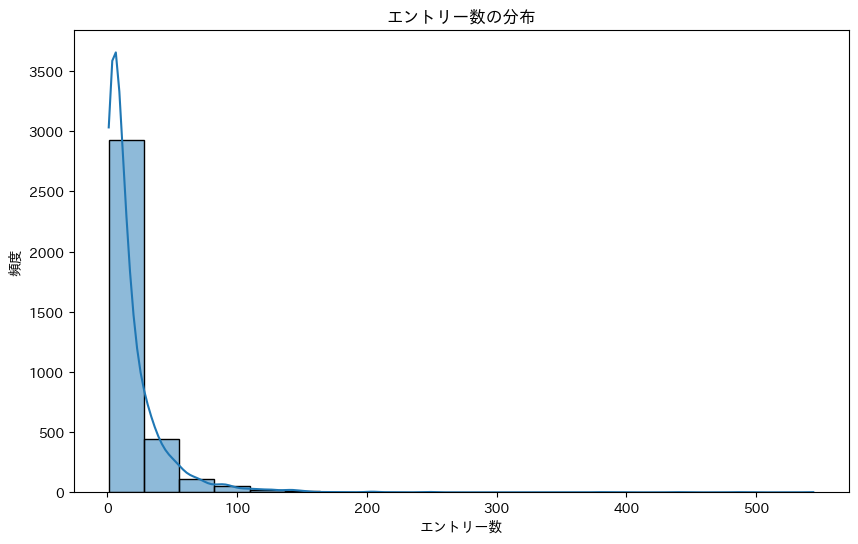


エントリー数ごとのサンプル数と構成比:


サンプル数    構成比
エントリー数              
1         334  9.31%
2         339  9.45%
3         233   6.5%
4         222  6.19%
5         152  4.24%
...       ...    ...
380         1  0.03%
394         1  0.03%
439         1  0.03%
486         1  0.03%
544         1  0.03%

[138 rows x 2 columns]

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# エントリー数のヒストグラム
plt.figure(figsize=(10, 6))
sns.histplot(df_merge_diff_unique_job_id['エントリー数'], bins=20, kde=True)
plt.title('エントリー数の分布')
plt.xlabel('エントリー数')
plt.ylabel('頻度')
plt.show()

# エントリー数ごとの数表（サンプル数と構成比）
entry_counts = df_merge_diff_unique_job_id['エントリー数'].value_counts().sort_index()
total_samples = df_merge_diff_unique_job_id['エントリー数'].count()

entry_frequency_table = pd.DataFrame({
    'サンプル数': entry_counts,
    '構成比': (entry_counts / total_samples * 100).round(2).astype(str) + '%'
})

print("\nエントリー数ごとのサンプル数と構成比:")
display(entry_frequency_table)


エントリー数が100件を超える会員は除外する

In [28]:
df_merge_diff_unique_job_id = df_merge_diff_unique_job_id[df_merge_diff_unique_job_id['エントリー数'] <= 100].copy()

print("Rows with 'エントリー数' greater than 100 removed successfully.")
print("New shape of df_merge_diff_unique_job_id:", df_merge_diff_unique_job_id.shape)
display(df_merge_diff_unique_job_id.head())

Rows with 'エントリー数' greater than 100 removed successfully.
New shape of df_merge_diff_unique_job_id: (3527, 40)


担当CP 人材ランク_x            応募経路  紹介経路 企業書類提出日 １次面接日                業種  \
0  谷本 若菜       A      Webマイページ経由  CP厳選     NaT   NaT              サービス   
1   上野 倭       C      Webマイページ経由  CP厳選     NaT   NaT  メーカー（素材・食品・医薬品他)   
3  仲田 祐亮       C      Webマイページ経由  CP厳選     NaT   NaT     IT・通信・インターネット   
4  小西 優歩       A  エージェントタブ（エン転職）  CP厳選     NaT   NaT             金融・保険   
5  山梶 詩織       C        マイページアプリ  CP厳選     NaT   NaT              サービス   

                                                  職種    求職者ID  \
0     Webマーケティング、SEO・SEMコンサルタント,マーケティングリサーチ、データ分析・解析  2428791   
1  社内情報戦略・推進、情報セキュリティ,プロジェクトマネージャー（Web・アプリ・オープン系）...  3651246   
3                    カスタマーサクセス,IT営業、技術営業、システム営業,法人営業  6739910   
4                                        総務,人事、労務、採用  4916880   
5                                           人事、労務、採用  6739106   

              求職者面談日時  ... 応募承諾→1面日数  登録→応募承諾日数 登録経路（大）  エントリー数 エントリー業種一致率  \
0 2025-06-17 10:00:00  ...         0       2549    スカウト       2        0.0   
1 2025-07-01 13:00:00  ...         0       2031      案件      34        0.0   
3 2025-05-30 20:00:00  ...         0         30      案件      58        0.0   
4 2025-06-06 10:00:00  ...         0       1327      新規       9        0.0   
5 2025-05-30 10:00:00  ...         0         31      新規      31        0.0   

  エントリー職種一致率   平均年収ギャップ＋   平均年収ギャップー  メイン紹介経路  BID  
0   0.000000  745.000000 -170.000000     CP厳選    0  
1   0.058824  152.647059   40.411765     CP厳選    0  
3   0.034483  285.103448 -110.775862     CP厳選    0  
4   0.555556  247.222222  -30.333333     CP厳選    0  
5   0.000000  151.096774    3.290323     CP厳選    0  

[5 rows x 40 columns]

## 基礎分析（EDA）

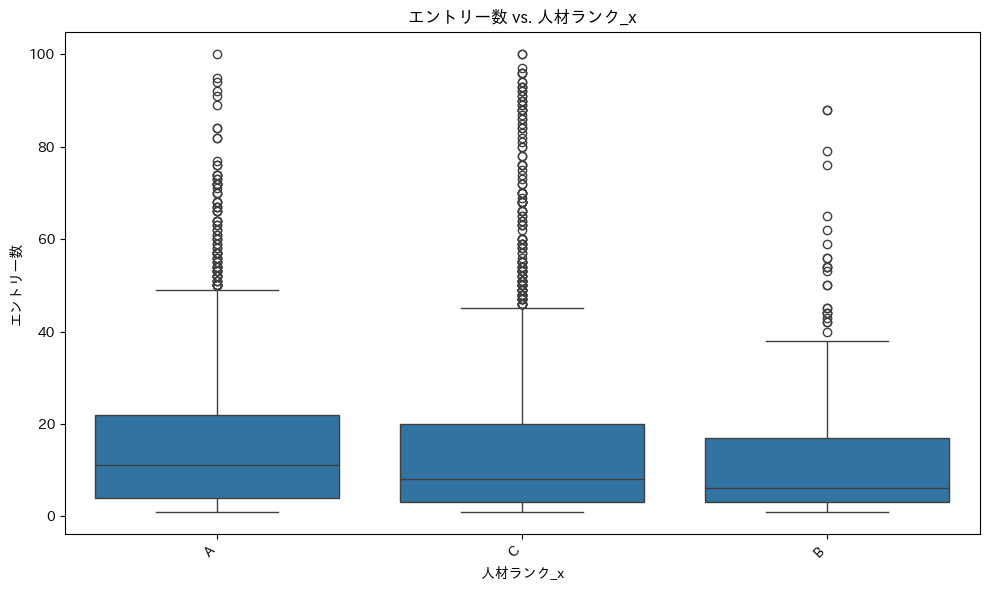

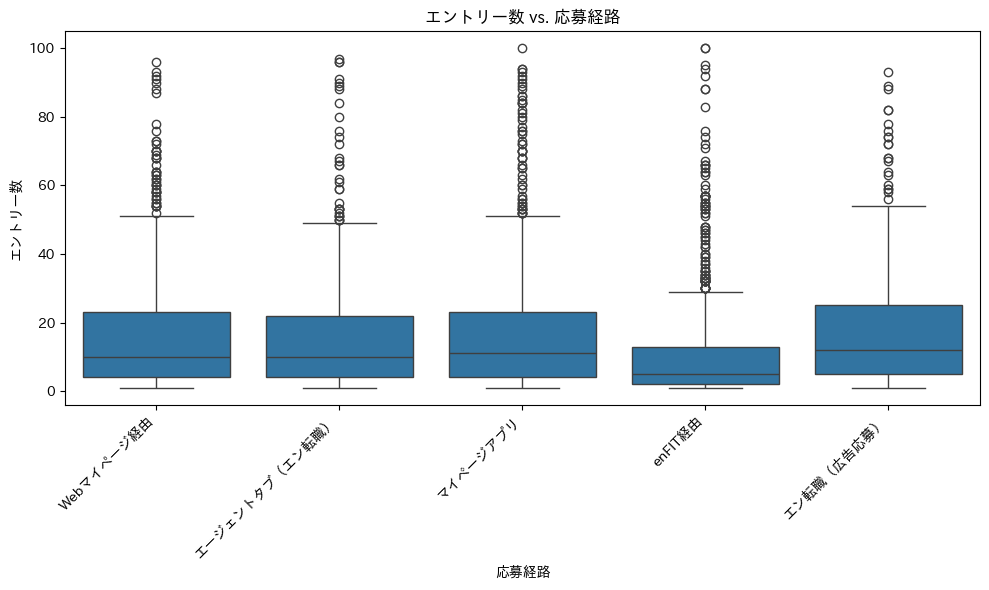

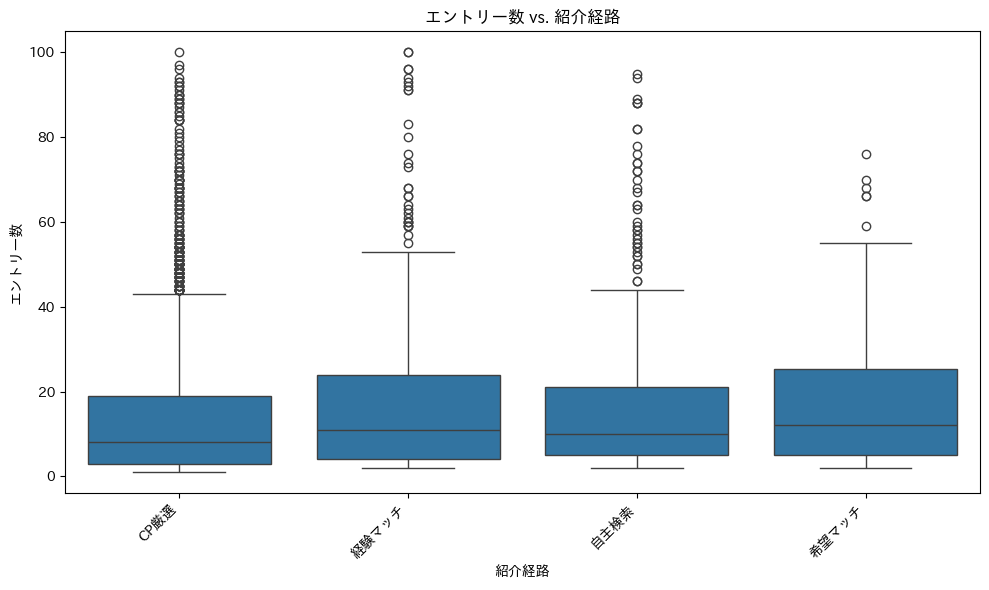

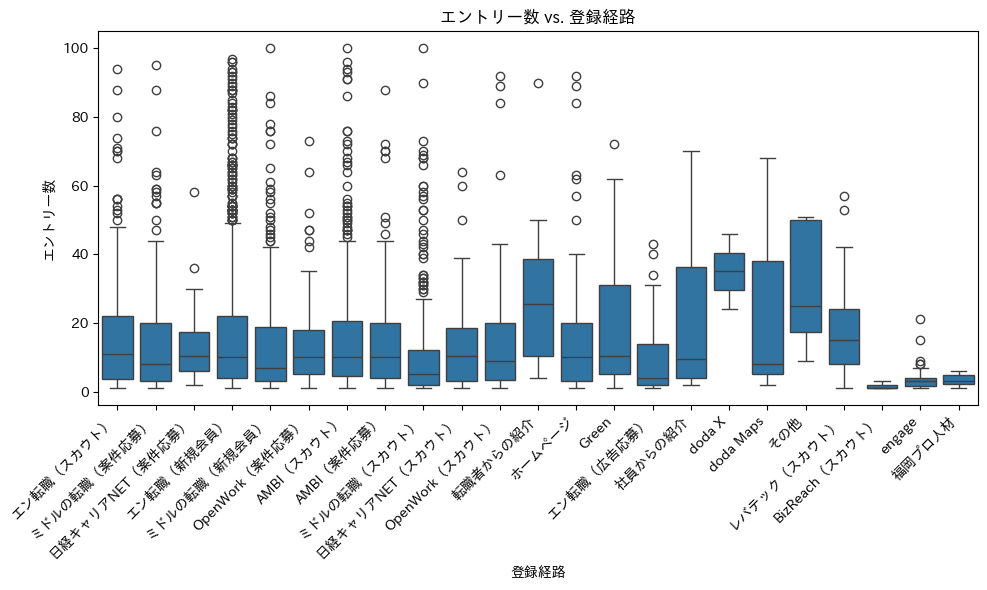

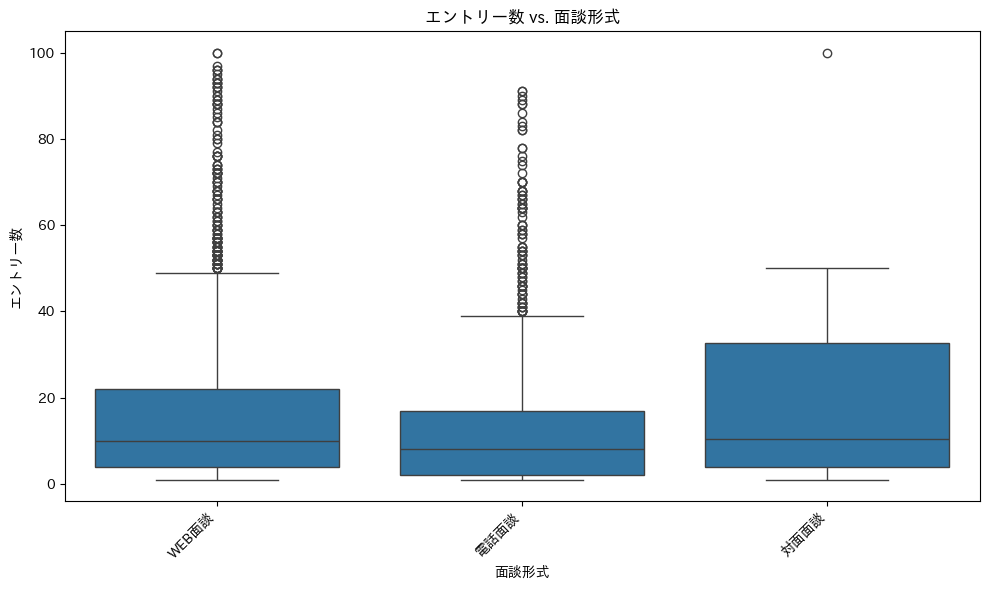

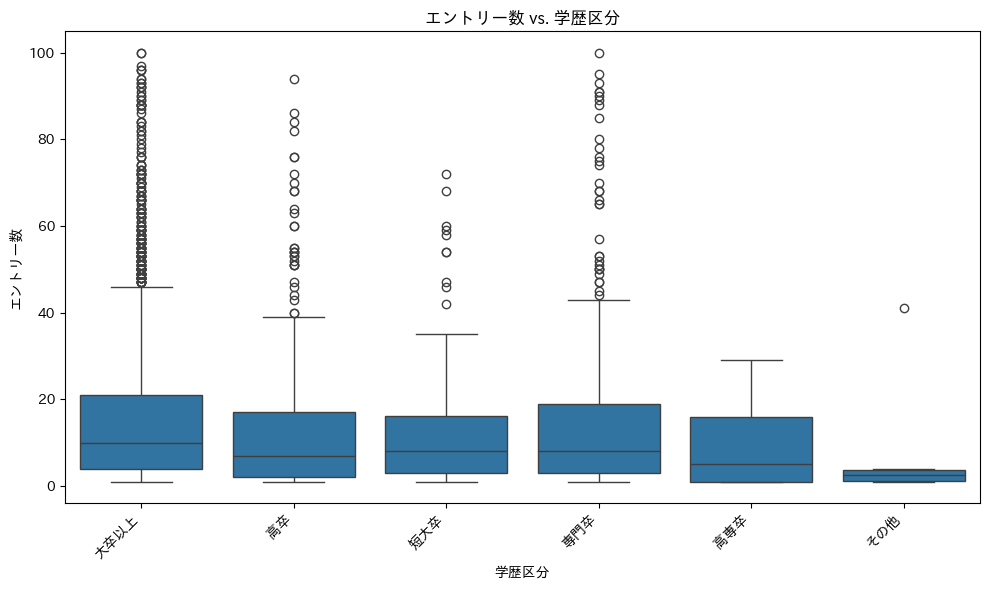

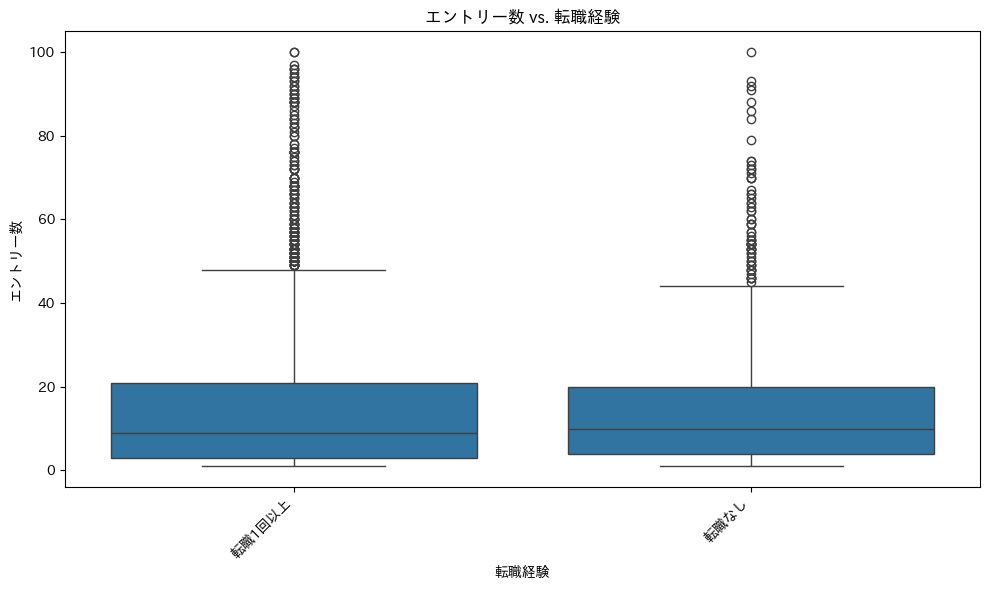

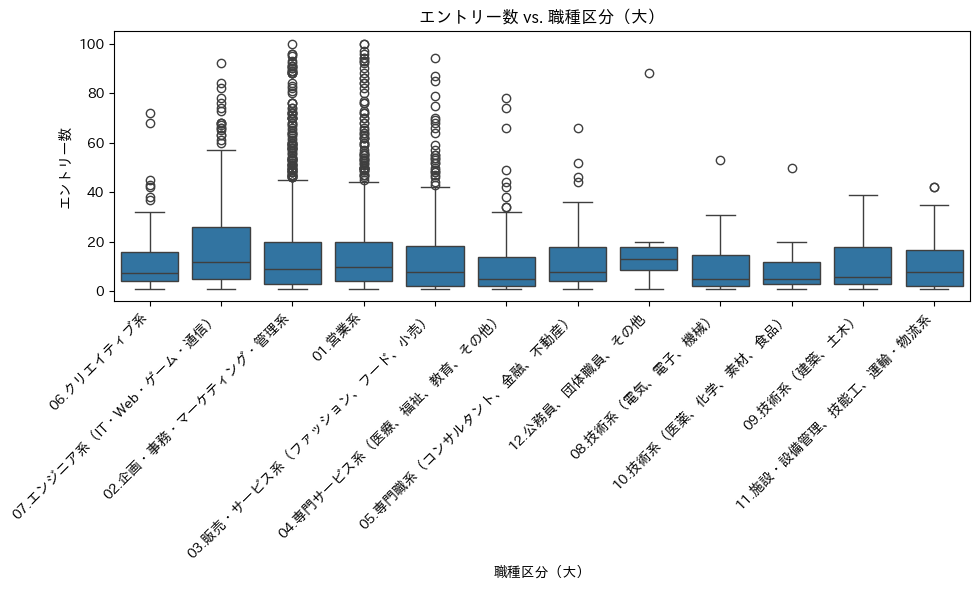

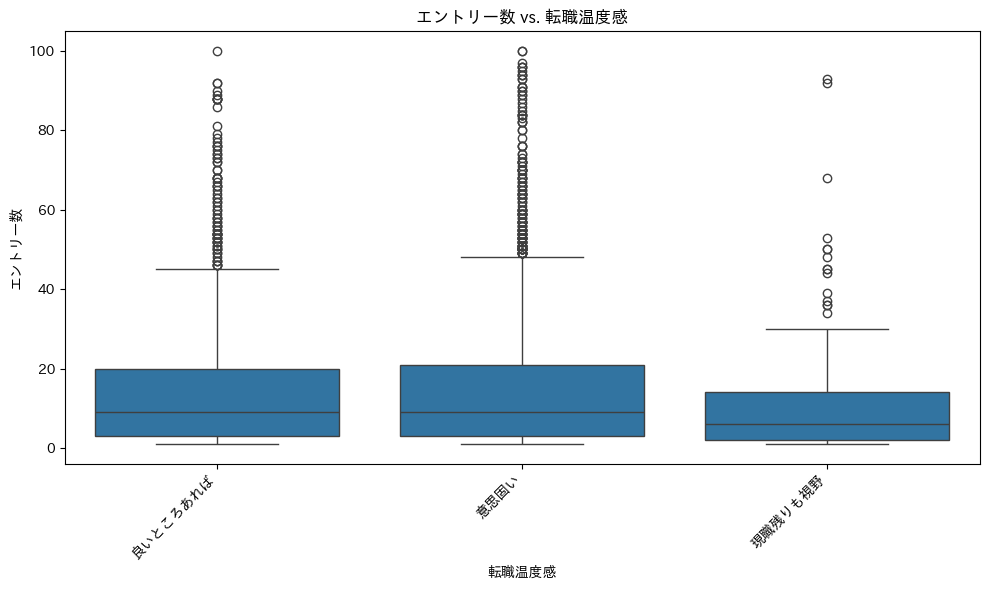

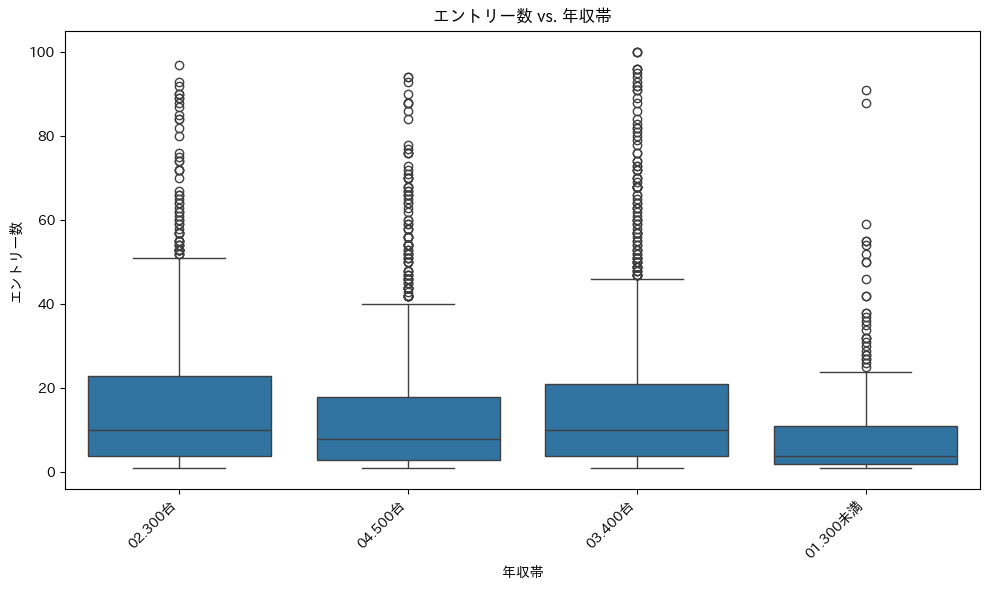

In [29]:
categorical_features_to_plot = [
    '人材ランク_x', '応募経路', '紹介経路', '登録経路', '面談形式',
    '学歴区分', '転職経験', '職種区分（大）', '転職温度感', '年収帯'
]

# Ensure 'エントリー数' is numeric for plotting
df_merge_diff_unique_job_id['エントリー数'] = pd.to_numeric(df_merge_diff_unique_job_id['エントリー数'], errors='coerce')

for feature in categorical_features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='エントリー数', data=df_merge_diff_unique_job_id)
    plt.title(f'エントリー数 vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('エントリー数')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


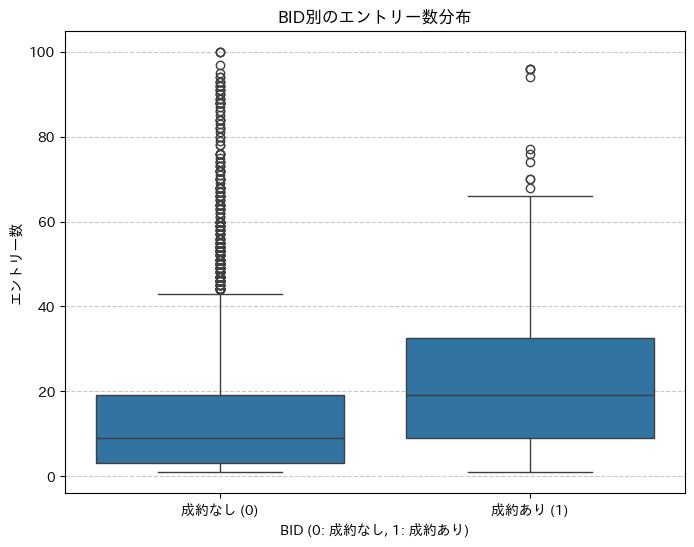

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='BID', y='エントリー数', data=df_merge_diff_unique_job_id)
plt.title('BID別のエントリー数分布')
plt.xlabel('BID (0: 成約なし, 1: 成約あり)')
plt.ylabel('エントリー数')
plt.xticks([0, 1], ['成約なし (0)', '成約あり (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 担当CPごとにデータセットを作成

In [32]:
unique_cps = df_merge_diff_unique_job_id['担当CP'].unique()

for cp_name in unique_cps:
    # Create a valid variable name by replacing spaces and special characters
    var_name = f"df_{cp_name.replace(' ', '_').replace('　', '_').replace('-', '_').replace('(', '').replace(')', '').replace('/', '_')}"
    globals()[var_name] = df_merge_diff_unique_job_id[df_merge_diff_unique_job_id['担当CP'] == cp_name].copy()
    print(f"Created DataFrame: {var_name} with {len(globals()[var_name])} rows.")

# Display the head of one of the created DataFrames as an example
# We will pick the first one for demonstration
if len(unique_cps) > 0:
    example_cp_name = unique_cps[0]
    example_var_name = f"df_{example_cp_name.replace(' ', '_').replace('　', '_').replace('-', '_').replace('(', '').replace(')', '').replace('/', '_')}"
    print(f"\nDisplaying head of {example_var_name}:")
    display(globals()[example_var_name].head())
else:
    print("No unique '担当CP' found to create DataFrames.")

Created DataFrame: df_谷本_若菜 with 90 rows.
Created DataFrame: df_上野_倭 with 2 rows.
Created DataFrame: df_仲田_祐亮 with 112 rows.
Created DataFrame: df_小西_優歩 with 86 rows.
Created DataFrame: df_山梶_詩織 with 12 rows.
Created DataFrame: df_白井_宏昂 with 61 rows.
Created DataFrame: df_松本_龍 with 63 rows.
Created DataFrame: df_布田_雄大 with 71 rows.
Created DataFrame: df_小室_匡史 with 37 rows.
Created DataFrame: df_大友_萌夏 with 5 rows.
Created DataFrame: df_小林_菜々美 with 3 rows.
Created DataFrame: df_古野_廉也 with 18 rows.
Created DataFrame: df_関_昇馬 with 10 rows.
Created DataFrame: df_冨永_雅斗 with 24 rows.
Created DataFrame: df_濱島_佳祐 with 78 rows.
Created DataFrame: df_高田_悠生 with 70 rows.
Created DataFrame: df_鈴木_香音 with 59 rows.
Created DataFrame: df_山田_侑輝 with 34 rows.
Created DataFrame: df_高田_さと with 97 rows.
Created DataFrame: df_小林_美優 with 90 rows.
Created DataFrame: df_佐藤_大介 with 86 rows.
Created DataFrame: df_浅野_千遥 with 67 rows.
Created DataFrame: df_高山_瑞生 with 70 rows.
Created DataFrame: df_山下_航代 with 105 r

担当CP 人材ランク_x            応募経路   紹介経路    企業書類提出日 １次面接日         業種  \
0   谷本 若菜       A      Webマイページ経由   CP厳選        NaT   NaT       サービス   
28  谷本 若菜       A  エージェントタブ（エン転職）   CP厳選        NaT   NaT       サービス   
61  谷本 若菜       C        マイページアプリ   CP厳選 2025-07-01   NaT       サービス   
66  谷本 若菜       C        マイページアプリ   CP厳選        NaT   NaT       サービス   
92  谷本 若菜       C        マイページアプリ  希望マッチ        NaT   NaT  不動産・建設・設備   

                                                職種    求職者ID  \
0   Webマーケティング、SEO・SEMコンサルタント,マーケティングリサーチ、データ分析・解析  2428791   
28                                        人事、労務、採用  1743880   
61                    営業事務・営業アシスタント,一般事務,カスタマーサクセス  5081827   
66                      店舗開発、FC開発（飲食・フード）,人事、労務、採用  4029743   
92                                   広告宣伝、PR,広報・IR  2509658   

               求職者面談日時  ... 応募承諾→1面日数  登録→応募承諾日数 登録経路（大）  エントリー数 エントリー業種一致率  \
0  2025-06-17 10:00:00  ...         0       2549    スカウト       2        0.0   
28 2025-06-20 18:00:00  ...         0       2851      案件      31        0.0   
61 2025-06-24 19:00:00  ...         0       1242      新規      18        0.0   
66 2025-04-11 16:00:00  ...         0       1825      新規      84        0.0   
92 2025-05-13 20:00:00  ...         0       2514      新規       6        0.0   

   エントリー職種一致率   平均年収ギャップ＋   平均年収ギャップー  メイン紹介経路  BID  
0    0.000000  745.000000 -170.000000     CP厳選    0  
28   0.612903  196.774194   14.967742     CP厳選    0  
61   0.000000   88.888889   44.833333     CP厳選    0  
66   0.547619  242.988095  -76.595238     CP厳選    0  
92   0.000000  503.166667 -210.666667     CP厳選    0  

[5 rows x 40 columns]

In [34]:
filtered_cp_dataframes_list = []

for var_name, var_value in globals().items():
    # Check if the variable name starts with 'df_' and is a pandas DataFrame
    if var_name.startswith('df_') and isinstance(var_value, pd.DataFrame):
        # Check if the DataFrame has between 10 and 200 (exclusive) rows
        if len(var_value) >= 10 and len(var_value) < 200:
            filtered_cp_dataframes_list.append(var_value)
            print(f"Added DataFrame '{var_name}' (rows: {len(var_value)}) to the filtered list.")

print(f"\nTotal DataFrames with 10 or more rows and less than 200 rows: {len(filtered_cp_dataframes_list)}")

Added DataFrame 'df_谷本_若菜' (rows: 90) to the filtered list.
Added DataFrame 'df_仲田_祐亮' (rows: 112) to the filtered list.
Added DataFrame 'df_小西_優歩' (rows: 86) to the filtered list.
Added DataFrame 'df_山梶_詩織' (rows: 12) to the filtered list.
Added DataFrame 'df_白井_宏昂' (rows: 61) to the filtered list.
Added DataFrame 'df_松本_龍' (rows: 63) to the filtered list.
Added DataFrame 'df_布田_雄大' (rows: 71) to the filtered list.
Added DataFrame 'df_小室_匡史' (rows: 37) to the filtered list.
Added DataFrame 'df_古野_廉也' (rows: 18) to the filtered list.
Added DataFrame 'df_関_昇馬' (rows: 10) to the filtered list.
Added DataFrame 'df_冨永_雅斗' (rows: 24) to the filtered list.
Added DataFrame 'df_濱島_佳祐' (rows: 78) to the filtered list.
Added DataFrame 'df_高田_悠生' (rows: 70) to the filtered list.
Added DataFrame 'df_鈴木_香音' (rows: 59) to the filtered list.
Added DataFrame 'df_山田_侑輝' (rows: 34) to the filtered list.
Added DataFrame 'df_高田_さと' (rows: 97) to the filtered list.
Added DataFrame 'df_小林_美優' (rows: 90) to 

全74名のエージェントの実績を分析する。そこから配布パターンを探索する。

## ①強みの取得

- Manhoitney's U-test



In [35]:
from scipy.stats import mannwhitneyu
import numpy as np

# Initialize an empty list to store statistical analysis results
statistical_results = []

categorical_features_to_plot = [
    '人材ランク_x',
    '応募経路',
    #'紹介経路',
    '業種',
    '職種',
    'コア経験職種_x',
    '求職者年齢',
    '登録経路',
    '面談形式',
    '学歴区分',
    '経験業種',
    '転職回数',
    '現在年収',
    '現在住所',
    '転職温度感',
    '年齢',
    '年収帯',
    '職種区分（大）',
    '転職経験',
    'エントリー業種一致率',
    'エントリー職種一致率',
    '平均年収ギャップ＋',
    '平均年収ギャップー',
    'メイン紹介経路',
    #'担当CP',
    'ランクギャップ',
    '登録→面談日数',
    '面談→応募承諾日数',
    '応募承諾→1面日数',
    '登録→応募承諾日数',
    '登録経路（大）'
]

for df_cp in filtered_cp_dataframes_list:
    if df_cp.empty:
        continue

    cp_name = df_cp['担当CP'].iloc[0]
    overall_mean_entries = df_cp['エントリー数'].mean()

    for feature in categorical_features_to_plot:
        if feature not in df_cp.columns:
            continue

        # Calculate mean entries and sample count for each category within the feature
        feature_stats = df_cp.groupby(feature)['エントリー数'].agg(
            mean_entries='mean',
            sample_count='count'
        ).reset_index()

        # Identify high-performing categories based on criteria
        high_performing_categories = feature_stats[
            (feature_stats['mean_entries'] >= 1.1 * overall_mean_entries) &
            (feature_stats['sample_count'] >= 4)
        ]

        for _, row in high_performing_categories.iterrows():
            category_value = row[feature]
            mean_entries_in_category = row['mean_entries']
            sample_count_in_category = row['sample_count']

            # Create group_a_data (high-performing category) and group_b_data (all other categories)
            group_a_data = df_cp[df_cp[feature] == category_value]['エントリー数'].values
            group_b_data = df_cp[df_cp[feature] != category_value]['エントリー数'].values

            # Ensure there are enough samples in both groups for statistical testing
            if len(group_a_data) > 1 and len(group_b_data) > 1: # mannwhitneyu requires >0 samples for each group
                # Perform Mann-Whitney U test
                statistic, p_value = mannwhitneyu(group_a_data, group_b_data, alternative='two-sided')

                # Calculate z-score (approximation for large N) and effect size r = z / sqrt(N)
                # N is the total number of observations
                N = len(group_a_data) + len(group_b_data)

                # Calculate expected U and std dev of U under null hypothesis
                n1 = len(group_a_data)
                n2 = len(group_b_data)

                # Handle cases where n1 or n2 is 0 to prevent division by zero or NaN results
                if n1 == 0 or n2 == 0:
                    effect_size_r = np.nan
                else:
                    mean_rank1 = (n1 + 1) / 2 # Expected mean rank for group1 if ranks were assigned randomly to group1
                    mean_rank2 = (n2 + 1) / 2 # Expected mean rank for group2 if ranks were assigned randomly to group2

                    # Z-score approximation for Mann-Whitney U test
                    # z = (U - E[U]) / std[U]
                    # E[U] = n1 * n2 / 2
                    # var[U] = n1 * n2 * (n1 + n2 + 1) / 12

                    # Use the returned 'statistic' as U for z-score calculation
                    U = statistic
                    expected_U = (n1 * n2) / 2
                    std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

                    # Avoid division by zero
                    if std_U != 0:
                        z_score = (U - expected_U) / std_U
                        effect_size_r = z_score / np.sqrt(N)
                    else: # If std_U is 0, all values are identical, so no effect
                        effect_size_r = 0.0 if U == expected_U else np.nan # If U differs from expected_U when std_U is 0, it's an extreme case, might be nan

                statistical_results.append({
                    'CP': cp_name,
                    'Feature': feature,
                    'Category': category_value,
                    'Mean_Entries_in_Category': mean_entries_in_category,
                    'p_value': p_value,
                    'effect_size': effect_size_r,
                    'Overall_Mean_Entries_for_CP': overall_mean_entries,
                    'Sample_Count_in_Category': sample_count_in_category
                })

# Create a new DataFrame from the statistical_results list
statistical_analysis_df = pd.DataFrame(statistical_results)

print("Statistical analysis completed and stored in 'statistical_analysis_df'.")
display(statistical_analysis_df.head())

Statistical analysis completed and stored in 'statistical_analysis_df'.


CP   Feature        Category  Mean_Entries_in_Category   p_value  \
0  谷本 若菜      応募経路  エージェントタブ（エン転職）                 24.600000  0.678240   
1  谷本 若菜        業種            サービス                 27.083333  0.483230   
2  谷本 若菜  コア経験職種_x        人事、労務、採用                 31.777778  0.080036   
3  谷本 若菜     求職者年齢            27.0                 23.200000  0.417238   
4  谷本 若菜     求職者年齢            30.0                 27.250000  0.095341   

   effect_size  Overall_Mean_Entries_for_CP  Sample_Count_in_Category  
0     0.044154                    20.366667                      25.0  
1     0.074444                    20.366667                      12.0  
2     0.185010                    20.366667                       9.0  
3     0.086339                    20.366667                       5.0  
4     0.176351                    20.366667                       8.0

In [36]:
# 1. Filter for statistically significant results with an effect size >= 0.5
high_impact_significant_results = statistical_analysis_df[
    (statistical_analysis_df['p_value'] <= 0.05) &
    (statistical_analysis_df['effect_size'].abs() >= 0.5)
].copy()

print("--- Statistically Significant Results with Effect Size >= 0.5 ---")
display(high_impact_significant_results)

# 2. Get the list of CPs, Features, and Categories
high_impact_list = high_impact_significant_results[['CP', 'Feature', 'Category']].values.tolist()

print("\n--- List of CP, Feature, Category for high-impact significant results ---")
for item in high_impact_list:
    print(f"CP: {item[0]}, Feature: {item[1]}, Category: {item[2]}")

# 3. Count unique CPs in the filtered list
unique_cps_count = high_impact_significant_results['CP'].nunique()
print(f"\n--- Number of Unique CPs with High-Impact Significant Results: {unique_cps_count} ---")

# 4. Count how many CPs have each significant Feature
cps_per_feature = high_impact_significant_results.groupby('Feature')['CP'].nunique().sort_values(ascending=False)
print("\n--- Number of Unique CPs per High-Impact Significant Feature ---")
display(cps_per_feature)

--- Statistically Significant Results with Effect Size >= 0.5 ---


CP    Feature              Category  \
121            山梶 詩織       現在住所                   東京都   
156             松本 龍    人材ランク_x                     A   
236            古野 廉也        年収帯               04.500台   
253            冨永 雅斗        年収帯               03.400台   
909             岡田 励  面談→応募承諾日数                   0.0   
1060           真下 佑季    登録経路（大）                    新規   
1132    エン エージェント事務局       学歴区分                  大卒以上   
1141           白井 杏弥       学歴区分                  大卒以上   
1151  エンエージェント面談事務局        登録経路            エン転職（新規会員）   
1157  エンエージェント面談事務局     登録経路（大）                    新規   
1196            井澤 真    職種区分（大）  02.企画・事務・マーケティング・管理系   
1234           三枝 奈央        年収帯               02.300台   
1258           阿部 風花       登録経路            エン転職（新規会員）   
1263           阿部 風花    登録経路（大）                    新規   
1268           吉野 大地       現在住所                   東京都   
1296           篠崎 美和       登録経路            エン転職（新規会員）   
1300           篠崎 美和    登録経路（大）                    新規   

      Mean_Entries_in_Category   p_value  effect_size  \
121                  21.625000  0.024603     0.661892   
156                  22.657143  0.000038     0.519318   
236                  10.272727  0.004448     0.672423   
253                  11.666667  0.006802     0.551135   
909                  24.629630  0.000115     0.551335   
1060                 10.571429  0.022300     0.513858   
1132                 12.857143  0.021035     0.756787   
1141                  9.181818  0.024720     0.548454   
1151                 30.666667  0.022174     0.715626   
1157                 30.666667  0.022174     0.715626   
1196                  4.000000  0.016276     0.738549   
1234                 10.428571  0.008669     0.577943   
1258                  3.800000  0.043983     0.562569   
1263                  3.800000  0.043983     0.562569   
1268                 13.000000  0.009592     0.674200   
1296                 28.000000  0.016162     0.686406   
1300                 28.000000  0.016162     0.686406   

      Overall_Mean_Entries_for_CP  Sample_Count_in_Category  
121                     15.000000                       8.0  
156                     16.126984                      35.0  
236                      6.888889                      11.0  
253                      6.333333                       6.0  
909                     17.224490                      27.0  
1060                     6.100000                       7.0  
1132                     9.600000                       7.0  
1141                     6.882353                      11.0  
1151                    19.181818                       6.0  
1157                    19.181818                       6.0  
1196                     3.181818                       8.0  
1234                     6.619048                       7.0  
1258                     3.307692                      10.0  
1263                     3.307692                      10.0  
1268                     5.266667                       4.0  
1296                    14.666667                       4.0  
1300                    14.666667                       4.0


--- List of CP, Feature, Category for high-impact significant results ---
CP: 山梶 詩織, Feature: 現在住所, Category: 東京都
CP: 松本 龍, Feature: 人材ランク_x, Category: A
CP: 古野 廉也, Feature: 年収帯, Category: 04.500台
CP: 冨永 雅斗, Feature: 年収帯, Category: 03.400台
CP: 岡田 励, Feature: 面談→応募承諾日数, Category: 0.0
CP: 真下 佑季, Feature: 登録経路（大）, Category: 新規
CP: エン エージェント事務局, Feature: 学歴区分, Category: 大卒以上
CP: 白井 杏弥, Feature: 学歴区分, Category: 大卒以上
CP: エンエージェント面談事務局 , Feature: 登録経路, Category: エン転職（新規会員）
CP: エンエージェント面談事務局 , Feature: 登録経路（大）, Category: 新規
CP: 井澤 真, Feature: 職種区分（大）, Category: 02.企画・事務・マーケティング・管理系
CP: 三枝 奈央, Feature: 年収帯, Category: 02.300台
CP: 阿部 風花, Feature: 登録経路, Category: エン転職（新規会員）
CP: 阿部 風花, Feature: 登録経路（大）, Category: 新規
CP: 吉野 大地, Feature: 現在住所, Category: 東京都
CP: 篠崎 美和, Feature: 登録経路, Category: エン転職（新規会員）
CP: 篠崎 美和, Feature: 登録経路（大）, Category: 新規

--- Number of Unique CPs with High-Impact Significant Results: 14 ---

--- Number of Unique CPs per High-Impact Significant Feature ---


Feature
登録経路（大）      4
年収帯          3
登録経路         3
学歴区分         2
現在住所         2
人材ランク_x      1
職種区分（大）      1
面談→応募承諾日数    1
Name: CP, dtype: int64

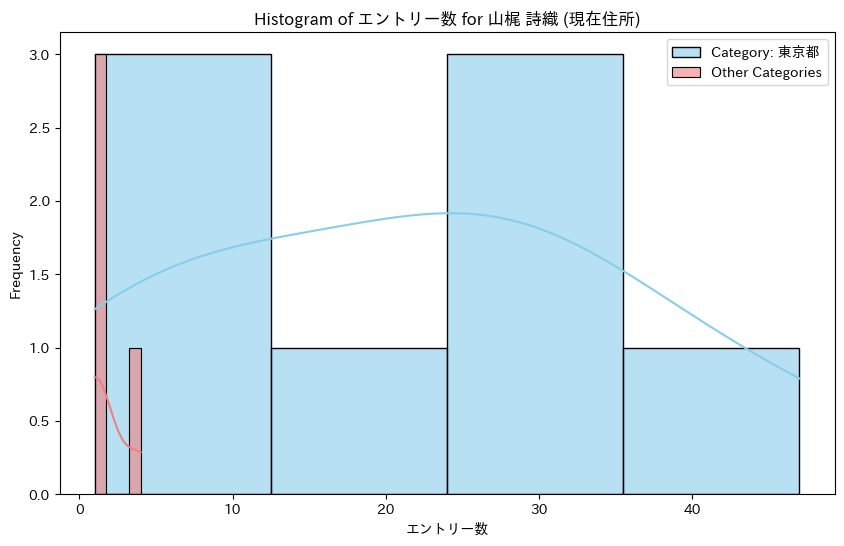

In [37]:
# Pick an example from the high_impact_significant_results
example_row = high_impact_significant_results.iloc[0]
example_cp = example_row['CP']
example_feature = example_row['Feature']
example_category = example_row['Category']

# Get the DataFrame for the selected CP
# Find the correct DataFrame from filtered_cp_dataframes_list
selected_df_cp = None
for df in filtered_cp_dataframes_list:
    if not df.empty and df['担当CP'].iloc[0] == example_cp:
        selected_df_cp = df
        break

if selected_df_cp is not None:
    # Extract data for the chosen category
    group_a_data = selected_df_cp[selected_df_cp[example_feature] == example_category]['エントリー数'].values
    # Extract data for all other categories within the same feature
    group_b_data = selected_df_cp[selected_df_cp[example_feature] != example_category]['エントリー数'].values

    plt.figure(figsize=(10, 6))
    sns.histplot(group_a_data, color='skyblue', label=f'Category: {example_category}', kde=True, alpha=0.6)
    sns.histplot(group_b_data, color='lightcoral', label='Other Categories', kde=True, alpha=0.6)
    plt.title(f'Histogram of エントリー数 for {example_cp} ({example_feature})')
    plt.xlabel('エントリー数')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
else:
    print(f"DataFrame for CP '{example_cp}' not found.")


In [38]:
# 1. Filter the statistical_analysis_df to keep only rows where the p_value is less than 0.05
significant_results_df = statistical_analysis_df[statistical_analysis_df['p_value'] < 0.05].copy()

# 2. From significant_results_df, group the data by the 'Feature' column and count the number of unique 'CP's for each feature.
cp_counts_per_significant_feature = significant_results_df.groupby('Feature')['CP'].nunique()

print("--- Statistically Significant Results (p-value < 0.05) ---")
display(significant_results_df)

print("\n--- Number of Unique CPs per Significant Feature ---")
display(cp_counts_per_significant_feature)


--- Statistically Significant Results (p-value < 0.05) ---


CP  Feature     Category  Mean_Entries_in_Category   p_value  \
31    谷本 若菜  ランクギャップ         -2.0                 31.800000  0.046285   
44    仲田 祐亮       職種  人事、労務、採用,総務                 37.571429  0.004526   
64    仲田 祐亮    転職温度感         意思固い                 20.825000  0.021936   
121   山梶 詩織     現在住所          東京都                 21.625000  0.024603   
132   白井 宏昂     登録経路        Green                 39.500000  0.013198   
...     ...      ...          ...                       ...       ...   
1258  阿部 風花     登録経路   エン転職（新規会員）                  3.800000  0.043983   
1263  阿部 風花  登録経路（大）           新規                  3.800000  0.043983   
1268  吉野 大地     現在住所          東京都                 13.000000  0.009592   
1296  篠崎 美和     登録経路   エン転職（新規会員）                 28.000000  0.016162   
1300  篠崎 美和  登録経路（大）           新規                 28.000000  0.016162   

      effect_size  Overall_Mean_Entries_for_CP  Sample_Count_in_Category  
31       0.210742                    20.366667                       5.0  
44       0.268615                    18.017857                       7.0  
64       0.216657                    18.017857                      80.0  
121      0.661892                    15.000000                       8.0  
132      0.318954                    18.918033                       4.0  
...           ...                          ...                       ...  
1258     0.562569                     3.307692                      10.0  
1263     0.562569                     3.307692                      10.0  
1268     0.674200                     5.266667                       4.0  
1296     0.686406                    14.666667                       4.0  
1300     0.686406                    14.666667                       4.0  

[114 rows x 8 columns]


--- Number of Unique CPs per Significant Feature ---


Feature
コア経験職種_x     3
ランクギャップ      7
人材ランク_x      9
学歴区分         6
年収帯          7
年齢           4
応募経路         6
業種           5
求職者年齢        4
現在住所         5
現在年収         9
登録→応募承諾日数    2
登録→面談日数      2
登録経路         6
登録経路（大）      7
経験業種         2
職種           3
職種区分（大）      6
転職回数         8
転職温度感        3
転職経験         4
面談→応募承諾日数    6
Name: CP, dtype: int64

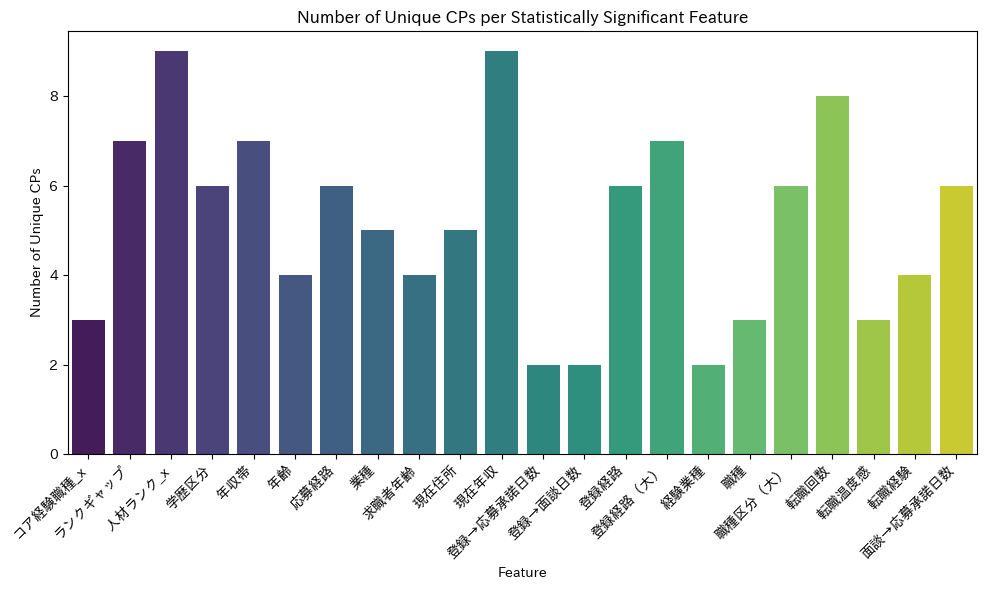

In [39]:
# Create a bar plot using the cp_counts_per_significant_feature Series
plt.figure(figsize=(10, 6))
sns.barplot(x=cp_counts_per_significant_feature.index, y=cp_counts_per_significant_feature.values, hue=cp_counts_per_significant_feature.index, palette='viridis', legend=False)

# Set the title and labels
plt.title('Number of Unique CPs per Statistically Significant Feature')
plt.xlabel('Feature')
plt.ylabel('Number of Unique CPs')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Ensure all elements fit within the figure area
plt.tight_layout()

# Display the plot
plt.show()

In [40]:
# 1. Create a new DataFrame called max_effect_categories_df by copying significant_results_df.
max_effect_categories_df = significant_results_df.copy()

# 2. Add a new column to max_effect_categories_df named 'abs_effect_size' which contains the absolute value of the 'effect_size' column.
max_effect_categories_df['abs_effect_size'] = max_effect_categories_df['effect_size'].abs()

# 3. Group max_effect_categories_df by 'CP' and 'Feature' and for each group, select the row with the maximum 'abs_effect_size'.
# 4. Overwrite max_effect_categories_df with the result.
max_effect_categories_df = max_effect_categories_df.loc[max_effect_categories_df.groupby(['CP', 'Feature'])['abs_effect_size'].idxmax()]

print("max_effect_categories_df created and filtered successfully.")
display(max_effect_categories_df.head())

max_effect_categories_df created and filtered successfully.


CP   Feature    Category  Mean_Entries_in_Category  \
1132    エン エージェント事務局      学歴区分        大卒以上                 12.857143   
1151  エンエージェント面談事務局       登録経路  エン転職（新規会員）                 30.666667   
1157  エンエージェント面談事務局    登録経路（大）          新規                 30.666667   
593            三室 佑奈  コア経験職種_x    人事、労務、採用                 33.285714   
604            三室 佑奈      現在年収       550.0                 27.500000   

       p_value  effect_size  Overall_Mean_Entries_for_CP  \
1132  0.021035     0.756787                     9.600000   
1151  0.022174     0.715626                    19.181818   
1157  0.022174     0.715626                    19.181818   
593   0.015428     0.278163                    15.657895   
604   0.042580     0.232981                    15.657895   

      Sample_Count_in_Category  abs_effect_size  
1132                       7.0         0.756787  
1151                       6.0         0.715626  
1157                       6.0         0.715626  
593                        7.0         0.278163  
604                        8.0         0.232981

In [41]:
# Create a cross-tabulation (pivot table)
cp_feature_crosstab = max_effect_categories_df.pivot_table(
    index='CP',
    columns='Feature',
    values='Category',
    aggfunc='first' # Use 'first' to handle potential multiple categories with same max abs_effect_size if not already unique
).fillna('') # Fill NaN values with an empty string for graceful handling

print("CP x Feature cross-tabulation created successfully.")
display(cp_feature_crosstab)


CP x Feature cross-tabulation created successfully.


Feature         コア経験職種_x ランクギャップ 人材ランク_x  学歴区分       年収帯    年齢  \
CP                                                               
エン エージェント事務局                              大卒以上                   
エンエージェント面談事務局                                                    
三室 佑奈           人事、労務、採用                                         
三村 知央                                                     36.0   
三枝 奈央                        1.0                 02.300台         
中川 梨寿                                       高卒                   
久保田 綾香                                                    27.0   
五十嵐 虎汰                                 A         02.300台         
井澤 真                                                             
井田 怜那                                     大卒以上                   
仲田 祐亮                                                            
佐藤 大介                                                            
冨永 雅斗                                            03.400台         
出野 宏和                                                            
前田 佳乃                                                            
古野 廉也                                            04.500台         
吉野 大地                                                            
大沢 のど花                                                           
安東 優希                        0.0       A         02.300台         
安田 凜太                                                            
宮田 京佳                       -2.0       A                         
小口 紗也乃                                                           
小室 匡史                        1.0                 03.400台         
小林 美優            経理、経理事務                                         
山下 航代                        0.0       A                         
山本 莉子                                  A                         
山梶 詩織                                                            
山田 侑輝                                                            
岡田 励                                   C                         
布田 雄大                                                     30.0   
平野 美唯                                                            
新倉 理央                                                            
松本 龍                                   A        01.300未満         
森本 寛大               個人営業                                         
泉川 万絢                        2.0                                 
浅野 千遥                                  A                         
田中 優菜                                                            
白井 宏昂                                       高卒                   
白井 杏弥                                     大卒以上                   
真下 佑季                                       高卒                   
石川                                                        47.0   
石田 有花                                                            
篠崎 美和                                                            
谷本 若菜                       -2.0                                 
鈴木 香音                                                            
阿部 風花                                                            
雑賀 千紘                                                            
高山 瑞生                                                            
高木 慶仁                                                            
高田 さと                                                            
高田 悠生                                  A                         

Feature                   応募経路             業種 求職者年齢  現在住所  ... 登録→面談日数  \
CP                                                         ...           
エン エージェント事務局                                               ...           
エンエージェント面談事務局                                              ...           
三室 佑奈                                                      ...           
三村 知央                                          36.0        ...           
三枝 奈央                                                    

In [42]:
# 'effect_size' が 0.5 を超える組み合わせを特定
high_effect_mask_df = max_effect_categories_df[max_effect_categories_df['abs_effect_size'] > 0.5]

# high_effect_crosstab と low_effect_crosstab を初期化
high_effect_crosstab = pd.DataFrame('', index=cp_feature_crosstab.index, columns=cp_feature_crosstab.columns)
low_effect_crosstab = pd.DataFrame('', index=cp_feature_crosstab.index, columns=cp_feature_crosstab.columns)

# high_effect_crosstab を埋める
for index, row in high_effect_mask_df.iterrows():
    cp = row['CP']
    feature = row['Feature']
    category = row['Category']
    if cp in high_effect_crosstab.index and feature in high_effect_crosstab.columns:
        high_effect_crosstab.loc[cp, feature] = category

# low_effect_crosstab を埋める（high_effect_crosstab に含まれないオリジナルの値をコピー）
for cp in cp_feature_crosstab.index:
    for feature in cp_feature_crosstab.columns:
        if high_effect_crosstab.loc[cp, feature] == '':
            low_effect_crosstab.loc[cp, feature] = cp_feature_crosstab.loc[cp, feature]

print("--- Effect Sizeが0.5を超えるCP x Featureクロス集計 --- ")
display(high_effect_crosstab.head())

print("\n--- Effect Sizeが0.5以下のCP x Featureクロス集計 --- ")
display(low_effect_crosstab.head())


# high_effect_crosstabをExcelファイルとしてダウンロード
high_effect_crosstab.to_excel('high_effect_crosstab.xlsx', index=True)
print("high_effect_crosstab.xlsx をダウンロードしました。")

# low_effect_crosstabをExcelファイルとしてダウンロード
low_effect_crosstab.to_excel('low_effect_crosstab.xlsx', index=True)
print("low_effect_crosstab.xlsx をダウンロードしました。")

--- Effect Sizeが0.5を超えるCP x Featureクロス集計 --- 


Feature        コア経験職種_x ランクギャップ 人材ランク_x  学歴区分      年収帯 年齢 応募経路 業種 求職者年齢 現在住所  \
CP                                                                             
エン エージェント事務局                             大卒以上                                  
エンエージェント面談事務局                                                                  
三室 佑奈                                                                          
三村 知央                                                                          
三枝 奈央                                          02.300台                         

Feature         ... 登録→面談日数        登録経路 登録経路（大） 経験業種 職種 職種区分（大） 転職回数 転職温度感  \
CP              ...                                                          
エン エージェント事務局    ...                                                          
エンエージェント面談事務局   ...          エン転職（新規会員）      新規                              
三室 佑奈           ...                                                          
三村 知央           ...                                                          
三枝 奈央           ...                                                          

Feature        転職経験 面談→応募承諾日数  
CP                             
エン エージェント事務局                   
エンエージェント面談事務局                  
三室 佑奈                          
三村 知央                          
三枝 奈央                          

[5 rows x 22 columns]


--- Effect Sizeが0.5以下のCP x Featureクロス集計 --- 


Feature         コア経験職種_x ランクギャップ 人材ランク_x 学歴区分 年収帯    年齢 応募経路 業種 求職者年齢 現在住所  \
CP                                                                           
エン エージェント事務局                                                                 
エンエージェント面談事務局                                                                
三室 佑奈           人事、労務、採用                                                     
三村 知央                                              36.0          36.0        
三枝 奈央                        1.0                                             

Feature         ... 登録→面談日数 登録経路 登録経路（大） 経験業種 職種 職種区分（大） 転職回数 転職温度感 転職経験  \
CP              ...                                                        
エン エージェント事務局    ...                                                        
エンエージェント面談事務局   ...                                                        
三室 佑奈           ...                                                        
三村 知央           ...                                       3.0              
三枝 奈央           ...                                                        

Feature        面談→応募承諾日数  
CP                        
エン エージェント事務局              
エンエージェント面談事務局             
三室 佑奈                4.0  
三村 知央                     
三枝 奈央                     

[5 rows x 22 columns]

high_effect_crosstab.xlsx をダウンロードしました。
low_effect_crosstab.xlsx をダウンロードしました。


## ②シミュレーション
- 入社決定率がリフトする可能性のある属性＆強みとしているCPが多い属性を候補として、介入効果推定を行う。
- アルゴリズム：X-learner
- モデル：LightGBM

<候補特徴>

- 人材ランク
- 現在年収
- 転職回数
- （効果薄そうだが）登録経路

In [58]:
columns_to_analyze = ['人材ランク_x', '現在年収', '転職回数']

for col in columns_to_analyze:
    print(f"\n--- カラム: {col} --- ")
    # Calculate value counts and reset index to make it a DataFrame for display
    counts = df_merge_diff_unique_job_id[col].value_counts().reset_index()
    counts.columns = [col, '求職者ID数']

    # Sort by '求職者ID数' in descending order for better readability
    counts = counts.sort_values(by='求職者ID数', ascending=False)

    # Format the output similar to the user's example
    for index, row in counts.iterrows():
        print(f"{row[col]} \t {row['求職者ID数']}人")

    # For numerical columns like '現在年収' and '転職回数', if there are many unique values,
    # it might be useful to mention that binning could provide more insight, but for now,
    # we provide the exact counts as per the request.
    if col in ['現在年収', '転職回数'] and len(counts) > 20:
        print(f"(上記以外に {len(counts) - 20} 件のユニークな値があります。必要であれば、これらのカラムはビン化して集計することも可能です。)")


--- カラム: 人材ランク_x --- 
C 	 1826人
A 	 1283人
B 	 418人

--- カラム: 現在年収 --- 
500.0 	 235.0人
450.0 	 225.0人
400.0 	 223.0人
550.0 	 206.0人
325.0 	 191.0人
425.0 	 187.0人
525.0 	 176.0人
350.0 	 159.0人
375.0 	 158.0人
475.0 	 155.0人
575.0 	 135.0人
420.0 	 104.0人
300.0 	 101.0人
480.0 	 74.0人
430.0 	 71.0人
380.0 	 69.0人
360.0 	 64.0人
449.0 	 61.0人
275.0 	 58.0人
520.0 	 53.0人
580.0 	 47.0人
330.0 	 44.0人
370.0 	 42.0人
530.0 	 40.0人
320.0 	 36.0人
540.0 	 29.0人
460.0 	 28.0人
250.0 	 25.0人
390.0 	 25.0人
470.0 	 25.0人
225.0 	 24.0人
570.0 	 24.0人
0.0 	 24.0人
490.0 	 23.0人
440.0 	 22.0人
590.0 	 22.0人
340.0 	 20.0人
301.0 	 20.0人
560.0 	 19.0人
410.0 	 17.0人
200.0 	 16.0人
510.0 	 14.0人
280.0 	 11.0人
401.0 	 9.0人
351.0 	 9.0人
310.0 	 9.0人
451.0 	 8.0人
175.0 	 8.0人
290.0 	 7.0人
270.0 	 7.0人
260.0 	 5.0人
435.0 	 5.0人
324.0 	 4.0人
240.0 	 4.0人
312.0 	 4.0人
495.0 	 4.0人
408.0 	 4.0人
385.0 	 4.0人
501.0 	 4.0人
336.0 	 3.0人
100.0 	 3.0人
515.0 	 3.0人
288.0 	 3.0人
150.0 	 3.0人
216.0 	 2.0人
103.0 	 2.0人
445.0 	 2.0人
413

In [63]:
# 現在年収_bin の作成
# 単位が「万円」なので、そのままの数値で比較します。
# 600万以上はフィルタリングで除外されているため、500~599万が最大範囲になります。
# 境界値を定義
bins_current_salary = [-float('inf'), 299, 399, 499, 599, float('inf')]
labels_current_salary = ['299万以下', '300~399万', '400~499万', '500~599万', '600万以上']

# pd.cut を使用して新しいカラムを作成
df_merge_diff_unique_job_id['現在年収_bin'] = pd.cut(
    df_merge_diff_unique_job_id['現在年収'],
    bins=bins_current_salary,
    labels=labels_current_salary,
    right=True, # right=Trueは区間の右端を含む (例: (299, 399] )
    include_lowest=True # include_lowest=Trueは最も低い区間の左端を含む
)

print("新しいカラム '現在年収_bin' が作成されました。")
print(df_merge_diff_unique_job_id[['現在年収', '現在年収_bin']].head())
display(df_merge_diff_unique_job_id['現在年収_bin'].value_counts().sort_index())

# 転職回数_bin の作成
# 境界値を定義
bins_job_change = [-float('inf'), 0.5, 2.5, 5.5, float('inf')]
labels_job_change = ['0回', '1回～2回', '3回～5回', '6回以上']

# pd.cut を使用して新しいカラムを作成
df_merge_diff_unique_job_id['転職回数_bin'] = pd.cut(
    df_merge_diff_unique_job_id['転職回数'],
    bins=bins_job_change,
    labels=labels_job_change,
    right=True, # right=Trueは区間の右端を含む (例: (0.5, 2.5] )
    include_lowest=True # include_lowest=Trueは最も低い区間の左端を含む
)

print("\n新しいカラム '転職回数_bin' が作成されました。")
print(df_merge_diff_unique_job_id[['転職回数', '転職回数_bin']].head())
display(df_merge_diff_unique_job_id['転職回数_bin'].value_counts().sort_index())

新しいカラム '現在年収_bin' が作成されました。
    現在年収  現在年収_bin
0  375.0  300~399万
1  575.0  500~599万
3  301.0  300~399万
4  425.0  400~499万
5  400.0  400~499万


現在年収_bin
299万以下       228
300~399万     989
400~499万    1276
500~599万    1034
600万以上         0
Name: count, dtype: int64


新しいカラム '転職回数_bin' が作成されました。
   転職回数 転職回数_bin
0   1.0    1回～2回
1   5.0    3回～5回
3   3.0    3回～5回
4   1.0    1回～2回
5   1.0    1回～2回


転職回数_bin
0回       1138
1回～2回    1616
3回～5回     725
6回以上       48
Name: count, dtype: int64

In [62]:
selected_features = ['人材ランク_x', '年収帯', '現在年収', '転職回数']

# Filter significant_results_df based on the selected features
filtered_results = significant_results_df[
    significant_results_df['Feature'].isin(selected_features)
].copy()

print("指定された特徴量におけるCPとカテゴリーの一覧:")
display(filtered_results[['CP', 'Feature', 'Category']])

指定された特徴量におけるCPとカテゴリーの一覧:


CP  Feature  Category
138    白井 宏昂     転職回数       2.0
156     松本 龍  人材ランク_x         A
174     松本 龍      年収帯  01.300未満
202    布田 雄大     現在年収     500.0
227    小室 匡史      年収帯   03.400台
236    古野 廉也      年収帯   04.500台
251    冨永 雅斗     現在年収     425.0
253    冨永 雅斗      年収帯   03.400台
290    高田 悠生  人材ランク_x         A
332    鈴木 香音     転職回数       1.0
429    佐藤 大介     現在年収     300.0
448    浅野 千遥  人材ランク_x         A
501    山下 航代  人材ランク_x         A
523    山下 航代     現在年収     360.0
604    三室 佑奈     現在年収     550.0
652    前田 佳乃     転職回数       4.0
662    宮田 京佳  人材ランク_x         A
671    宮田 京佳     現在年収     375.0
740   五十嵐 虎汰  人材ランク_x         A
753   五十嵐 虎汰     現在年収     375.0
761   五十嵐 虎汰      年収帯   02.300台
801    安東 優希  人材ランク_x         A
808    安東 優希     転職回数       0.0
811    安東 優希      年収帯   02.300台
829    高木 慶仁     転職回数       3.0
847    山本 莉子  人材ランク_x         A
894     岡田 励  人材ランク_x         C
917    三村 知央     転職回数       3.0
918    三村 知央     現在年収     450.0
1026  小口 紗也乃     転職回数       2.0
1165   出野 宏和     転職回数       1.0
1233   三枝 奈央     現在年収     300.0
1234   三枝 奈央      年収帯   02.300台

In [64]:
def process_category_to_segment(row):
    category_value = row['Category']
    feature_name = row['Feature']

    # Handle direct string replacements for 年収帯
    if category_value == '01.300未満':
        return '299万以下'
    elif category_value == '02.300台':
        return '300~399万'
    elif category_value == '03.400台':
        return '400~499万'
    elif category_value == '04.500台':
        return '500~599万'
    elif category_value == '05.600以上':
        return '600万以上'

    # Handle numerical data based on feature_name and specified ranges
    try:
        # Attempt to convert category_value to float, coercing errors to NaN
        numeric_value = pd.to_numeric(category_value, errors='coerce')

        if pd.notna(numeric_value):
            # Rule: 0から10.0の間の数字データは転職回数_bin作成時のルールに従って変換
            # We explicitly check the feature name to ensure correct binning logic is applied.
            if feature_name == '転職回数':
                # Use pd.cut for a single value by creating a Series for proper application of bins/labels
                return pd.cut([numeric_value], bins=bins_job_change, labels=labels_job_change, right=True, include_lowest=True)[0]
            # Rule: 100.0以上の数字データなら現在年収_bin作成時のルールに従って変換
            elif feature_name == '現在年収':
                # Use pd.cut for a single value by creating a Series
                return pd.cut([numeric_value], bins=bins_current_salary, labels=labels_current_salary, right=True, include_lowest=True)[0]
            else:
                return category_value # If numeric but not explicitly '転職回数' or '現在年収', keep original
        else:
            # If conversion to numeric resulted in NaN (original was non-numeric string like 'A', '東京都', '新規')
            return category_value
    except (ValueError, TypeError):
        # If it's a non-numeric string (e.g., 'A', '東京都', '新規'), return as is
        return category_value

# Ensure the bins_current_salary, labels_current_salary, bins_job_change, labels_job_change are defined.
# They should be defined from the previous successful execution in the notebook.

# Apply the function to create the new 'Segment' column
filtered_results['Segment'] = filtered_results.apply(process_category_to_segment, axis=1)

print("新しいカラム 'Segment' が作成されました。")
display(filtered_results[['CP', 'Feature', 'Category', 'Segment']].head(10))

新しいカラム 'Segment' が作成されました。


CP  Feature  Category   Segment
138  白井 宏昂     転職回数       2.0     1回～2回
156   松本 龍  人材ランク_x         A         A
174   松本 龍      年収帯  01.300未満    299万以下
202  布田 雄大     現在年収     500.0  500~599万
227  小室 匡史      年収帯   03.400台  400~499万
236  古野 廉也      年収帯   04.500台  500~599万
251  冨永 雅斗     現在年収     425.0  400~499万
253  冨永 雅斗      年収帯   03.400台  400~499万
290  高田 悠生  人材ランク_x         A         A
332  鈴木 香音     転職回数       1.0     1回～2回

In [65]:
print("SegmentごとのCPの分布:")
display(filtered_results['Segment'].value_counts())

SegmentごとのCPの分布:


Segment
A           8
300~399万    8
1回～2回       4
400~499万    4
500~599万    3
3回～5回       3
299万以下      1
0回          1
C           1
Name: count, dtype: int64

## 補足：LightGBMによる会員入社決定率予測

### モデルの定義

In [43]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define target and features
target = 'BID'
features = [
    '人材ランク_x',
    '応募経路',
    #'紹介経路',
    '業種',
    '職種',
    'コア経験職種_x',
    '求職者年齢',
    '登録経路',
    '面談形式',
    '学歴区分',
    '経験業種',
    '転職回数',
    '現在年収',
    '現在住所',
    '転職温度感',
    '年齢',
    '年収帯',
    '職種区分（大）',
    '転職経験',
    'エントリー業種一致率',
    'エントリー職種一致率',
    '平均年収ギャップ＋',
    '平均年収ギャップー',
    'メイン紹介経路',
    #'担当CP',
    'ランクギャップ',
    '登録→面談日数',
    '面談→応募承諾日数',
    '応募承諾→1面日数',
    '登録→応募承諾日数',
    '登録経路（大）'
]

X = df_merge_diff_unique_job_id[features].copy()
Y = df_merge_diff_unique_job_id[target].copy()

# Identify categorical and numerical features
categorical_features_lgbm = [col for col in features if X[col].dtype == 'object' or X[col].dtype == 'category']
numerical_features_lgbm = [col for col in features if col not in categorical_features_lgbm]

# Label Encode categorical features for LightGBM
for col in categorical_features_lgbm:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    # Convert to category type explicitly for LightGBM if not already
    X[col] = X[col].astype('category')

# Convert numerical features to appropriate types if they were object before imputation
for col in numerical_features_lgbm:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    # Impute any NaNs that might have been introduced by to_numeric if not handled earlier
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)

print("Features (X) and Target (Y) defined and preprocessed for LightGBM.")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")


Features (X) and Target (Y) defined and preprocessed for LightGBM.
X shape: (3527, 29), Y shape: (3527,)


### 学習

In [44]:
# Cross-validation setup
n_splits = 4  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

auc_scores = []
f1_scores = []

# --- Manual Threshold for F1 Score ---
# You can change this value to experiment with different thresholds
manual_threshold = 0.12 # Example: setting a lower threshold to potentially increase recall

# LightGBM Model Training and Evaluation
print(f"Starting {n_splits}-fold Stratified Cross-Validation...")

for fold, (train_index, val_index) in enumerate(skf.split(X, Y)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]

    # Initialize LGBM Classifier
    # Pass categorical_feature names as they are now integer-encoded 'category' dtype
    lgbm_model = lgb.LGBMClassifier(
        objective='binary', # Binary classification
        metric='auc',      # Evaluation metric
        random_state=42,
        n_estimators=317, # Increased estimators for potentially better performance
        learning_rate=0.031038962077954348,
        num_leaves=164,
        max_depth=-21,
        colsample_bytree=0.6583642483401746,
        subsample=0.6354161113920438,
        reg_alpha=2.8817133873870833,
        reg_lambda=2.3088849374114805e-06
    )

    # Train the model, explicitly telling LightGBM which features are categorical
    lgbm_model.fit(X_train, Y_train,
                    eval_set=[(X_val, Y_val)],
                    eval_metric='auc', # Monitor AUC during training
                    callbacks=[lgb.early_stopping(100, verbose=False)], # Early stopping to prevent overfitting
                    categorical_feature=[col for col in categorical_features_lgbm if col in X_train.columns]
                   )

    # Predictions for evaluation
    y_pred_proba = lgbm_model.predict_proba(X_val)[:, 1] # Probabilities for AUC

    # --- Apply manual threshold for F1 score calculation ---
    y_pred = (y_pred_proba >= manual_threshold).astype(int) # Class labels for F1 based on custom threshold

    # Calculate scores
    fold_auc = roc_auc_score(Y_val, y_pred_proba)
    fold_f1 = f1_score(Y_val, y_pred)

    auc_scores.append(fold_auc)
    f1_scores.append(fold_f1)

    print(f"Fold AUC: {fold_auc:.4f}")
    print(f"Fold F1 Score (threshold={manual_threshold}): {fold_f1:.4f}")

# Summarize cross-validation results
print("\n--- Cross-Validation Results ---")
print(f"Mean AUC: {np.mean(auc_scores):.4f} (+/- {np.std(auc_scores):.4f})")
print(f"Mean F1 Score (threshold={manual_threshold}): {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})")

Starting 4-fold Stratified Cross-Validation...

--- Fold 1/4 ---
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

### ハイパーパラメータチューニング（最適化）

In [45]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 7.9 MB/s eta 0:00:00


In [46]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

def objective(trial):
    # 3. Hyperparameter suggestions
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 2, 64),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        # Add other parameters as needed
    }

    # 4. Initialize out-of-fold predictions array
    oof_preds = np.zeros(len(X))

    # 5. Iterate through StratifiedKFold splits
    # Using the previously defined skf if it exists, otherwise define it
    try:
        skf # check if skf is defined
    except NameError:
        skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(skf.split(X, Y)):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        Y_train_fold, Y_val_fold = Y.iloc[train_index], Y.iloc[val_index]

        # 7. Create an lgb.LGBMClassifier model
        model = lgb.LGBMClassifier(**params)

        # 8. Fit the LightGBM model
        model.fit(X_train_fold, Y_train_fold,
                  eval_set=[(X_val_fold, Y_val_fold)],
                  eval_metric='auc',
                  callbacks=[lgb.early_stopping(100, verbose=False)],
                  categorical_feature=categorical_features_lgbm
                 )

        # 9. Predict probabilities on X_val_fold and append them to oof_preds
        oof_preds[val_index] = model.predict_proba(X_val_fold)[:, 1]

    # 10. Calculate the AUC score
    auc_score = roc_auc_score(Y, oof_preds)

    # 11. Return the calculated AUC score
    return auc_score

print("LightGBM objective function for Optuna defined successfully.")



# Create an Optuna study object
study = optuna.create_study(direction='maximize') # We want to maximize AUC

# Run the optimization process
# You can adjust n_trials based on computational resources and desired exploration
print("Starting Optuna hyperparameter optimization...")
study.optimize(objective, n_trials=50) # Running 50 trials for demonstration
print("Optuna optimization finished.")

# Print the best trial's value and parameters
print("\nBest trial (Maximum AUC) reached by Optuna:")
print(f"  Value: {study.best_value:.4f}")
print("  Params: ")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

[I 2026-02-02 05:16:56,571] A new study created in memory with name: no-name-d761bc9d-ac2a-41d0-8a07-090d99c6427b


LightGBM objective function for Optuna defined successfully.
Starting Optuna hyperparameter optimization...
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2026-02-02 05:16:57,627] Trial 0 finished with value: 0.736477034824648 and parameters: {'n_estimators': 125, 'learning_rate': 0.035470685796818474, 'num_leaves': 13, 'max_depth': 3, 'reg_alpha': 1.092088700509049e-05, 'reg_lambda': 2.088867225913144e-08, 'colsample_bytree': 0.4605584570052216, 'subsample': 0.7876570436227526}. Best is trial 0 with value: 0.736477034824648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing 

[I 2026-02-02 05:17:03,872] Trial 1 finished with value: 0.7395322845139248 and parameters: {'n_estimators': 787, 'learning_rate': 0.039631712741302706, 'num_leaves': 201, 'max_depth': 36, 'reg_alpha': 1.9580848424675465, 'reg_lambda': 0.001602690333542679, 'colsample_bytree': 0.8249519077552323, 'subsample': 0.8513802590493791}. Best is trial 1 with value: 0.7395322845139248.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:

[I 2026-02-02 05:17:07,489] Trial 2 finished with value: 0.6767791571953138 and parameters: {'n_estimators': 134, 'learning_rate': 0.11399089406266931, 'num_leaves': 51, 'max_depth': 26, 'reg_alpha': 6.466210148908719e-07, 'reg_lambda': 0.0001250941973940064, 'colsample_bytree': 0.9702238834792097, 'subsample': 0.9150534581844765}. Best is trial 1 with value: 0.7395322845139248.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2026-02-02 05:17:09,669] Trial 3 finished with value: 0.6628084195403656 and parameters: {'n_estimators': 51, 'learning_rate': 0.18691495355143806, 'num_leaves': 235, 'max_depth': 29, 'reg_alpha': 0.0011044994880554503, 'reg_lambda': 4.405515430418182e-06, 'colsample_bytree': 0.7361615164824087, 'subsample': 0.7457185513902463}. Best is trial 1 with value: 0.7395322845139248.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:17:17,909] Trial 4 finished with value: 0.7317949178414295 and parameters: {'n_estimators': 474, 'learning_rate': 0.038467049448372384, 'num_leaves': 101, 'max_depth': 37, 'reg_alpha': 1.3536206599047596e-05, 'reg_lambda': 2.0925693671977936, 'colsample_bytree': 0.5593695043467339, 'subsample': 0.8979528824191302}. Best is trial 1 with value: 0.7395322845139248.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:17:23,491] Trial 5 finished with value: 0.7398418264391338 and parameters: {'n_estimators': 188, 'learning_rate': 0.023884628703580497, 'num_leaves': 75, 'max_depth': 8, 'reg_alpha': 0.02021158114320178, 'reg_lambda': 6.678537749071867e-07, 'colsample_bytree': 0.43857910005651357, 'subsample': 0.8364934683504978}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2026-02-02 05:17:25,160] Trial 6 finished with value: 0.7027871769303837 and parameters: {'n_estimators': 398, 'learning_rate': 0.2881223081487883, 'num_leaves': 10, 'max_depth': 4, 'reg_alpha': 0.05435046001043761, 'reg_lambda': 5.009511111282842e-05, 'colsample_bytree': 0.6655925799359443, 'subsample': 0.462502136845584}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:17:27,044] Trial 7 finished with value: 0.7295300633733927 and parameters: {'n_estimators': 676, 'learning_rate': 0.10685969116726873, 'num_leaves': 197, 'max_depth': 25, 'reg_alpha': 6.493993446719227, 'reg_lambda': 0.001272083842188712, 'colsample_bytree': 0.8594862778495144, 'subsample': 0.565889164197089}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:17:30,706] Trial 8 finished with value: 0.7118991696715075 and parameters: {'n_estimators': 822, 'learning_rate': 0.09481610874129494, 'num_leaves': 158, 'max_depth': 11, 'reg_alpha': 6.161722492330167e-08, 'reg_lambda': 1.547971229579671e-08, 'colsample_bytree': 0.4905359025166519, 'subsample': 0.8746319866133272}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:17:36,573] Trial 9 finished with value: 0.7153502077002689 and parameters: {'n_estimators': 763, 'learning_rate': 0.025992916894822714, 'num_leaves': 42, 'max_depth': 21, 'reg_alpha': 0.01332027082805879, 'reg_lambda': 0.000702150283314146, 'colsample_bytree': 0.5098899189691781, 'subsample': 0.8892624843574364}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:17:39,085] Trial 10 finished with value: 0.7139206438472043 and parameters: {'n_estimators': 279, 'learning_rate': 0.010419700263700942, 'num_leaves': 105, 'max_depth': 57, 'reg_alpha': 0.12452506104242489, 'reg_lambda': 9.953375592301638e-07, 'colsample_bytree': 0.4098270239880326, 'subsample': 0.6188664946116872}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:17:41,831] Trial 11 finished with value: 0.7391743028217936 and parameters: {'n_estimators': 611, 'learning_rate': 0.013542803588703703, 'num_leaves': 156, 'max_depth': 42, 'reg_alpha': 3.874662603241863, 'reg_lambda': 0.05884444474295931, 'colsample_bytree': 0.7896306871486324, 'subsample': 0.9876582011256403}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:17:44,273] Trial 12 finished with value: 0.7300132795848829 and parameters: {'n_estimators': 956, 'learning_rate': 0.020175193382878303, 'num_leaves': 252, 'max_depth': 48, 'reg_alpha': 0.4130835586712501, 'reg_lambda': 0.009374605127699262, 'colsample_bytree': 0.6324240843717266, 'subsample': 0.7887423564093666}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.07334

[I 2026-02-02 05:17:46,849] Trial 13 finished with value: 0.6659286494047817 and parameters: {'n_estimators': 324, 'learning_rate': 0.06386557396676258, 'num_leaves': 83, 'max_depth': 16, 'reg_alpha': 0.002102721875577268, 'reg_lambda': 8.702614472890941e-07, 'colsample_bytree': 0.886177256675687, 'subsample': 0.6795448454886822}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:17:50,038] Trial 14 finished with value: 0.7261014730414975 and parameters: {'n_estimators': 973, 'learning_rate': 0.019166665744267432, 'num_leaves': 201, 'max_depth': 61, 'reg_alpha': 0.8027380199066053, 'reg_lambda': 0.9771404195637827, 'colsample_bytree': 0.594909407176071, 'subsample': 0.8291781380678541}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:17:53,026] Trial 15 finished with value: 0.6814990808258862 and parameters: {'n_estimators': 555, 'learning_rate': 0.049980236738294506, 'num_leaves': 144, 'max_depth': 49, 'reg_alpha': 0.00010944028189521704, 'reg_lambda': 1.1756954828882881e-05, 'colsample_bytree': 0.7615136284525219, 'subsample': 0.67913171960032}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:17:55,574] Trial 16 finished with value: 0.7128478802285412 and parameters: {'n_estimators': 842, 'learning_rate': 0.028032842391949503, 'num_leaves': 206, 'max_depth': 32, 'reg_alpha': 0.005515735007864166, 'reg_lambda': 0.06284454180904732, 'colsample_bytree': 0.8482742505381788, 'subsample': 0.9746081943364422}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:17:58,115] Trial 17 finished with value: 0.666793476462999 and parameters: {'n_estimators': 243, 'learning_rate': 0.06443166772877004, 'num_leaves': 70, 'max_depth': 39, 'reg_alpha': 0.07942550419360545, 'reg_lambda': 4.741715424138955e-07, 'colsample_bytree': 0.9888797404796664, 'subsample': 0.7365825991634667}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:18:01,089] Trial 18 finished with value: 0.7242465844057031 and parameters: {'n_estimators': 684, 'learning_rate': 0.0170853519773975, 'num_leaves': 125, 'max_depth': 13, 'reg_alpha': 0.00017671223136758027, 'reg_lambda': 0.004435344437629131, 'colsample_bytree': 0.6925885222203605, 'subsample': 0.8276207424887628}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:05,776] Trial 19 finished with value: 0.6738290572439899 and parameters: {'n_estimators': 482, 'learning_rate': 0.040835756121410625, 'num_leaves': 127, 'max_depth': 47, 'reg_alpha': 0.01463144571641867, 'reg_lambda': 2.9822530706150568e-05, 'colsample_bytree': 0.7949343848878629, 'subsample': 0.41519212543927125}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:08,395] Trial 20 finished with value: 0.7325770428585605 and parameters: {'n_estimators': 376, 'learning_rate': 0.02520201834431889, 'num_leaves': 177, 'max_depth': 19, 'reg_alpha': 1.0509689133422917, 'reg_lambda': 1.313380849205779e-07, 'colsample_bytree': 0.9157108018003752, 'subsample': 0.6088190105636557}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:10,900] Trial 21 finished with value: 0.7068608431827526 and parameters: {'n_estimators': 565, 'learning_rate': 0.010622387875271066, 'num_leaves': 173, 'max_depth': 41, 'reg_alpha': 9.059904626592031, 'reg_lambda': 0.09133295825664264, 'colsample_bytree': 0.8066239879738599, 'subsample': 0.9720708783826568}. Best is trial 5 with value: 0.7398418264391338.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:14,496] Trial 22 finished with value: 0.7426997726875328 and parameters: {'n_estimators': 684, 'learning_rate': 0.012468856510020712, 'num_leaves': 222, 'max_depth': 34, 'reg_alpha': 1.8077332624338645, 'reg_lambda': 0.03846471739386605, 'colsample_bytree': 0.7294001246389373, 'subsample': 0.9913343068673387}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:18:18,172] Trial 23 finished with value: 0.7074946952547931 and parameters: {'n_estimators': 732, 'learning_rate': 0.014997254702529062, 'num_leaves': 217, 'max_depth': 34, 'reg_alpha': 0.26190605535212436, 'reg_lambda': 0.006811318930927909, 'colsample_bytree': 0.7197010478490494, 'subsample': 0.9410555604649837}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:22,194] Trial 24 finished with value: 0.7376525852658044 and parameters: {'n_estimators': 890, 'learning_rate': 0.02196696700631299, 'num_leaves': 251, 'max_depth': 32, 'reg_alpha': 1.2513848640964045, 'reg_lambda': 0.2761220503586977, 'colsample_bytree': 0.6508734065502527, 'subsample': 0.8362855442240257}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:24,431] Trial 25 finished with value: 0.7332351148140622 and parameters: {'n_estimators': 774, 'learning_rate': 0.0311823574655658, 'num_leaves': 223, 'max_depth': 8, 'reg_alpha': 0.03428622333885312, 'reg_lambda': 0.00036032568200301585, 'colsample_bytree': 0.4048873405080959, 'subsample': 0.934572156475832}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You

[I 2026-02-02 05:18:27,761] Trial 26 finished with value: 0.7367676734261802 and parameters: {'n_estimators': 672, 'learning_rate': 0.013666170630999487, 'num_leaves': 180, 'max_depth': 23, 'reg_alpha': 1.6008213964722189, 'reg_lambda': 0.01997848963181648, 'colsample_bytree': 0.5765805447910706, 'subsample': 0.84150669590866}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2026-02-02 05:18:30,064] Trial 27 finished with value: 0.6703053595648456 and parameters: {'n_estimators': 614, 'learning_rate': 0.07977283932114385, 'num_leaves': 237, 'max_depth': 54, 'reg_alpha': 0.21816962996040173, 'reg_lambda': 0.0029206770753205003, 'colsample_bytree': 0.9234827005472516, 'subsample': 0.9999561463679785}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:18:32,128] Trial 28 finished with value: 0.6856064186235545 and parameters: {'n_estimators': 863, 'learning_rate': 0.05064061292729291, 'num_leaves': 38, 'max_depth': 44, 'reg_alpha': 0.0025033205620743405, 'reg_lambda': 0.00018697904623081552, 'colsample_bytree': 0.8430425374674237, 'subsample': 0.7786119184467795}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:34,592] Trial 29 finished with value: 0.7250180763032661 and parameters: {'n_estimators': 154, 'learning_rate': 0.036535608505620605, 'num_leaves': 67, 'max_depth': 36, 'reg_alpha': 0.0007201853183471181, 'reg_lambda': 0.7471536551237052, 'colsample_bytree': 0.7388463229258996, 'subsample': 0.8657111781701057}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data

[I 2026-02-02 05:18:38,716] Trial 30 finished with value: 0.7311262127663596 and parameters: {'n_estimators': 463, 'learning_rate': 0.012996170902426293, 'num_leaves': 27, 'max_depth': 28, 'reg_alpha': 1.7312450542822146e-05, 'reg_lambda': 7.366056595453955e-06, 'colsample_bytree': 0.6797981267794011, 'subsample': 0.7757152298027571}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:41,753] Trial 31 finished with value: 0.7406759355963762 and parameters: {'n_estimators': 621, 'learning_rate': 0.017030772498991535, 'num_leaves': 146, 'max_depth': 41, 'reg_alpha': 3.819399979163865, 'reg_lambda': 0.23717879100851752, 'colsample_bytree': 0.7767023929456559, 'subsample': 0.9578660391778736}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:18:42,974] Trial 32 finished with value: 0.7047259490649944 and parameters: {'n_estimators': 605, 'learning_rate': 0.017311525377999598, 'num_leaves': 111, 'max_depth': 2, 'reg_alpha': 3.3430695560965162, 'reg_lambda': 7.321493059511117, 'colsample_bytree': 0.7782047329984217, 'subsample': 0.9385527550093223}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:18:46,518] Trial 33 finished with value: 0.7141888347518702 and parameters: {'n_estimators': 710, 'learning_rate': 0.02258218913878021, 'num_leaves': 191, 'max_depth': 52, 'reg_alpha': 0.48792558087949134, 'reg_lambda': 0.03001678074072394, 'colsample_bytree': 0.8217482889445259, 'subsample': 0.919020523603}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:47,361] Trial 34 finished with value: 0.7312490843702595 and parameters: {'n_estimators': 74, 'learning_rate': 0.03276967442776459, 'num_leaves': 141, 'max_depth': 30, 'reg_alpha': 2.512222907166607, 'reg_lambda': 0.2734914478669021, 'colsample_bytree': 0.732914881726219, 'subsample': 0.9521816312825663}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073696 -> initscore=-2.531252
[LightGBM] [Info] Start training from score -2.531252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2026-02-02 05:18:49,156] Trial 35 finished with value: 0.725868725868726 and parameters: {'n_estimators': 786, 'learning_rate': 0.1508015392388942, 'num_leaves': 227, 'max_depth': 36, 'reg_alpha': 0.017124262223297694, 'reg_lambda': 7.234087729516442, 'colsample_bytree': 0.7535038324791267, 'subsample': 0.9074738107927584}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:52,672] Trial 36 finished with value: 0.7310742286262482 and parameters: {'n_estimators': 923, 'learning_rate': 0.041659812257020305, 'num_leaves': 89, 'max_depth': 44, 'reg_alpha': 1.1205577194085671e-06, 'reg_lambda': 0.0010002723613383813, 'colsample_bytree': 0.5360811083948303, 'subsample': 0.7182711856419385}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:56,047] Trial 37 finished with value: 0.7354527109729069 and parameters: {'n_estimators': 182, 'learning_rate': 0.011295621042522479, 'num_leaves': 165, 'max_depth': 39, 'reg_alpha': 0.09522243956729998, 'reg_lambda': 7.339654624566328e-08, 'colsample_bytree': 0.6077020754651528, 'subsample': 0.874951237569717}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:18:59,596] Trial 38 finished with value: 0.7091416473301418 and parameters: {'n_estimators': 651, 'learning_rate': 0.01645887749682985, 'num_leaves': 187, 'max_depth': 23, 'reg_alpha': 7.433180518215967, 'reg_lambda': 3.7559645633157584e-05, 'colsample_bytree': 0.9413133950558077, 'subsample': 0.7989713466289822}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:19:01,571] Trial 39 finished with value: 0.7390502497601641 and parameters: {'n_estimators': 496, 'learning_rate': 0.0273263145023083, 'num_leaves': 237, 'max_depth': 6, 'reg_alpha': 0.03625180687833788, 'reg_lambda': 0.20734208768631204, 'colsample_bytree': 0.874484887286959, 'subsample': 0.8975665803201585}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:19:03,321] Trial 40 finished with value: 0.7015306966347358 and parameters: {'n_estimators': 422, 'learning_rate': 0.27619837175442974, 'num_leaves': 215, 'max_depth': 28, 'reg_alpha': 0.20789509965038996, 'reg_lambda': 0.014262499267815778, 'colsample_bytree': 0.45989656834336035, 'subsample': 0.9742984659307891}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:19:07,349] Trial 41 finished with value: 0.7363175380311243 and parameters: {'n_estimators': 615, 'learning_rate': 0.012362733685990555, 'num_leaves': 155, 'max_depth': 43, 'reg_alpha': 3.8419426773048238, 'reg_lambda': 0.0735107321482057, 'colsample_bytree': 0.7114376037568346, 'subsample': 0.9978128528591643}. Best is trial 22 with value: 0.7426997726875328.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2026-02-02 05:19:12,139] Trial 42 finished with value: 0.7430364881405273 and parameters: {'n_estimators': 550, 'learning_rate': 0.013451033951497875, 'num_leaves': 142, 'max_depth': 39, 'reg_alpha': 2.6992131092516276, 'reg_lambda': 0.0016556721215336943, 'colsample_bytree': 0.8237928242894527, 'subsample': 0.9680455299656511}. Best is trial 42 with value: 0.7430364881405273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You

[I 2026-02-02 05:19:15,148] Trial 43 finished with value: 0.7026613516821596 and parameters: {'n_estimators': 553, 'learning_rate': 0.01875253494599899, 'num_leaves': 115, 'max_depth': 39, 'reg_alpha': 0.5157784390635044, 'reg_lambda': 0.0016253257449091536, 'colsample_bytree': 0.8350732021324917, 'subsample': 0.8599141036575952}. Best is trial 42 with value: 0.7430364881405273.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:19:17,078] Trial 44 finished with value: 0.7052847785711923 and parameters: {'n_estimators': 740, 'learning_rate': 0.015151543994936184, 'num_leaves': 139, 'max_depth': 34, 'reg_alpha': 9.94334469366396, 'reg_lambda': 0.00012090201244949852, 'colsample_bytree': 0.8873490626816588, 'subsample': 0.9561448807662469}. Best is trial 42 with value: 0.7430364881405273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:19:20,742] Trial 45 finished with value: 0.7033548673695552 and parameters: {'n_estimators': 520, 'learning_rate': 0.022372153660306204, 'num_leaves': 83, 'max_depth': 30, 'reg_alpha': 1.1760048160870547e-08, 'reg_lambda': 0.00045553446444273916, 'colsample_bytree': 0.7742715698280299, 'subsample': 0.9070130181305222}. Best is trial 42 with value: 0.7430364881405273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20

[I 2026-02-02 05:19:25,383] Trial 46 finished with value: 0.7338282065944245 and parameters: {'n_estimators': 810, 'learning_rate': 0.01217881685503452, 'num_leaves': 94, 'max_depth': 46, 'reg_alpha': 2.2282828836803468, 'reg_lambda': 0.0029927919968462256, 'colsample_bytree': 0.8124481818969768, 'subsample': 0.5383584386835183}. Best is trial 42 with value: 0.7430364881405273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.07334

[I 2026-02-02 05:19:29,788] Trial 47 finished with value: 0.7186470654952907 and parameters: {'n_estimators': 354, 'learning_rate': 0.01027832209606827, 'num_leaves': 61, 'max_depth': 51, 'reg_alpha': 0.6445109772377596, 'reg_lambda': 1.8217154055005784, 'colsample_bytree': 0.6663061467188258, 'subsample': 0.8028839498192626}. Best is trial 42 with value: 0.7430364881405273.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:19:33,660] Trial 48 finished with value: 0.716879014002637 and parameters: {'n_estimators': 635, 'learning_rate': 0.014008548869310564, 'num_leaves': 208, 'max_depth': 25, 'reg_alpha': 0.006517245324803227, 'reg_lambda': 9.882574947241739e-05, 'colsample_bytree': 0.4443078632099698, 'subsample': 0.8841291752440082}. Best is trial 42 with value: 0.7430364881405273.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:19:37,741] Trial 49 finished with value: 0.6836576040982405 and parameters: {'n_estimators': 438, 'learning_rate': 0.02011690880208984, 'num_leaves': 153, 'max_depth': 40, 'reg_alpha': 0.1342749749601219, 'reg_lambda': 2.048843425326534e-06, 'colsample_bytree': 0.6311680662385599, 'subsample': 0.921402492450646}. Best is trial 42 with value: 0.7430364881405273.


Optuna optimization finished.

Best trial (Maximum AUC) reached by Optuna:
  Value: 0.7430
  Params: 
    n_estimators: 550
    learning_rate: 0.013451033951497875
    num_leaves: 142
    max_depth: 39
    reg_alpha: 2.6992131092516276
    reg_lambda: 0.0016556721215336943
    colsample_bytree: 0.8237928242894527
    subsample: 0.9680455299656511


In [47]:
# Create an Optuna study object
study = optuna.create_study(direction='maximize') # We want to maximize AUC

# Run the optimization process
# You can adjust n_trials based on computational resources and desired exploration
print("Starting Optuna hyperparameter optimization...")
study.optimize(objective, n_trials=50) # Running 50 trials for demonstration
print("Optuna optimization finished.")

# Print the best trial's value and parameters
print("\nBest trial (Maximum AUC) reached by Optuna:")
print(f"  Value: {study.best_value:.4f}")
print("  Params: ")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

[I 2026-02-02 05:19:37,758] A new study created in memory with name: no-name-3db2e947-4b3c-4448-b674-fd17dd4e2a98


Starting Optuna hyperparameter optimization...
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2026-02-02 05:19:45,620] Trial 0 finished with value: 0.7381487975123225 and parameters: {'n_estimators': 202, 'learning_rate': 0.01577258180717306, 'num_leaves': 183, 'max_depth': 22, 'reg_alpha': 0.0014993975769135915, 'reg_lambda': 2.0868609795913924e-08, 'colsample_bytree': 0.5012040754936928, 'subsample': 0.8827419445726421}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:19:58,666] Trial 1 finished with value: 0.6820638176207332 and parameters: {'n_estimators': 371, 'learning_rate': 0.02419539413726475, 'num_leaves': 230, 'max_depth': 17, 'reg_alpha': 2.6358249294406028e-08, 'reg_lambda': 2.1944279731305527e-07, 'colsample_bytree': 0.851763352512034, 'subsample': 0.7287453727851358}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:20:04,196] Trial 2 finished with value: 0.7022466600189978 and parameters: {'n_estimators': 507, 'learning_rate': 0.06929048948654584, 'num_leaves': 211, 'max_depth': 5, 'reg_alpha': 0.4483274948944143, 'reg_lambda': 5.23754555299881e-07, 'colsample_bytree': 0.7449847171524462, 'subsample': 0.6215848223526542}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:20:08,868] Trial 3 finished with value: 0.7344555606489511 and parameters: {'n_estimators': 662, 'learning_rate': 0.037704621187850035, 'num_leaves': 200, 'max_depth': 61, 'reg_alpha': 6.638384191071356, 'reg_lambda': 0.35049308758769177, 'colsample_bytree': 0.7070346010815202, 'subsample': 0.6824795167664843}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:20:13,544] Trial 4 finished with value: 0.6974156793618238 and parameters: {'n_estimators': 278, 'learning_rate': 0.08618389177219458, 'num_leaves': 179, 'max_depth': 60, 'reg_alpha': 1.335046596409649e-07, 'reg_lambda': 2.2644786877438193e-05, 'colsample_bytree': 0.6083909232314952, 'subsample': 0.9001249629168854}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2026-02-02 05:20:15,538] Trial 5 finished with value: 0.7263271314678903 and parameters: {'n_estimators': 739, 'learning_rate': 0.13003897456599112, 'num_leaves': 231, 'max_depth': 48, 'reg_alpha': 7.260775483713022, 'reg_lambda': 2.577325361953768, 'colsample_bytree': 0.64188403566565, 'subsample': 0.7031509627101822}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2026-02-02 05:20:22,653] Trial 6 finished with value: 0.711786931187176 and parameters: {'n_estimators': 458, 'learning_rate': 0.0589475529834377, 'num_leaves': 196, 'max_depth': 36, 'reg_alpha': 0.0005318455060629901, 'reg_lambda': 7.164696997639122e-08, 'colsample_bytree': 0.5917128548227693, 'subsample': 0.45430455977306716}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:20:24,585] Trial 7 finished with value: 0.7027682736067069 and parameters: {'n_estimators': 418, 'learning_rate': 0.17605508773284775, 'num_leaves': 90, 'max_depth': 9, 'reg_alpha': 9.940951127674944e-05, 'reg_lambda': 0.04169009104663353, 'colsample_bytree': 0.5703006769547224, 'subsample': 0.5326895266859506}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:20:26,023] Trial 8 finished with value: 0.7110768750915629 and parameters: {'n_estimators': 549, 'learning_rate': 0.09548649666792668, 'num_leaves': 53, 'max_depth': 20, 'reg_alpha': 0.00032835101446483943, 'reg_lambda': 0.007291865308849602, 'colsample_bytree': 0.5726624182668377, 'subsample': 0.7191577573433403}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2026-02-02 05:20:27,684] Trial 9 finished with value: 0.7183121222288908 and parameters: {'n_estimators': 162, 'learning_rate': 0.03457043236417291, 'num_leaves': 95, 'max_depth': 30, 'reg_alpha': 0.45853715636406905, 'reg_lambda': 0.03596499793787309, 'colsample_bytree': 0.6254641510939201, 'subsample': 0.446350091026007}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:20:30,394] Trial 10 finished with value: 0.707495876712523 and parameters: {'n_estimators': 966, 'learning_rate': 0.010792793134520978, 'num_leaves': 142, 'max_depth': 34, 'reg_alpha': 1.6932816908516766e-06, 'reg_lambda': 3.470818695696804e-05, 'colsample_bytree': 0.4017823128975242, 'subsample': 0.9737068251393688}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:20:30,966] Trial 11 finished with value: 0.7159645657197676 and parameters: {'n_estimators': 51, 'learning_rate': 0.014866192537739565, 'num_leaves': 158, 'max_depth': 63, 'reg_alpha': 0.0667350336782547, 'reg_lambda': 8.512408742402833, 'colsample_bytree': 0.410343304707724, 'subsample': 0.849696214621874}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:20:35,949] Trial 12 finished with value: 0.6880242718676011 and parameters: {'n_estimators': 661, 'learning_rate': 0.027215653963938536, 'num_leaves': 249, 'max_depth': 48, 'reg_alpha': 0.007238905791737311, 'reg_lambda': 0.0009995466940864867, 'colsample_bytree': 0.9883577355781114, 'subsample': 0.8204456529436357}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:20:39,539] Trial 13 finished with value: 0.6815534278814573 and parameters: {'n_estimators': 827, 'learning_rate': 0.03906141841662033, 'num_leaves': 117, 'max_depth': 23, 'reg_alpha': 3.704521160375005e-06, 'reg_lambda': 4.294933567139582e-06, 'colsample_bytree': 0.7837607881823065, 'subsample': 0.6055284477983058}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing 

[I 2026-02-02 05:20:40,718] Trial 14 finished with value: 0.7008938909183706 and parameters: {'n_estimators': 247, 'learning_rate': 0.016240464933496134, 'num_leaves': 175, 'max_depth': 46, 'reg_alpha': 8.0666856473817, 'reg_lambda': 0.4757077266565765, 'colsample_bytree': 0.5027715847371028, 'subsample': 0.7876840575153018}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:20:42,797] Trial 15 finished with value: 0.7253855096572355 and parameters: {'n_estimators': 622, 'learning_rate': 0.018992812383595313, 'num_leaves': 39, 'max_depth': 13, 'reg_alpha': 0.004338570973671609, 'reg_lambda': 1.5438206557146918e-08, 'colsample_bytree': 0.8915005652856485, 'subsample': 0.9806713438640556}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:20:44,256] Trial 16 finished with value: 0.6701665382815933 and parameters: {'n_estimators': 862, 'learning_rate': 0.2971634737671358, 'num_leaves': 203, 'max_depth': 26, 'reg_alpha': 1.1048019260751543e-05, 'reg_lambda': 0.0003758280623910321, 'colsample_bytree': 0.4909760648652801, 'subsample': 0.6160144688178593}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:20:45,489] Trial 17 finished with value: 0.7204186613611339 and parameters: {'n_estimators': 83, 'learning_rate': 0.010095275074191808, 'num_leaves': 256, 'max_depth': 56, 'reg_alpha': 0.023808434554131834, 'reg_lambda': 0.22818189216937515, 'colsample_bytree': 0.6922920172334339, 'subsample': 0.8956432323172581}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:20:47,855] Trial 18 finished with value: 0.703241447427494 and parameters: {'n_estimators': 295, 'learning_rate': 0.04276773805844577, 'num_leaves': 129, 'max_depth': 39, 'reg_alpha': 0.30675954562092106, 'reg_lambda': 0.002477715935125571, 'colsample_bytree': 0.6981113646098602, 'subsample': 0.7683526655745558}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.07334

[I 2026-02-02 05:20:50,027] Trial 19 finished with value: 0.7291301399318535 and parameters: {'n_estimators': 608, 'learning_rate': 0.02334599961905885, 'num_leaves': 163, 'max_depth': 2, 'reg_alpha': 4.592164997607398e-05, 'reg_lambda': 2.5364852372557976e-05, 'colsample_bytree': 0.5016554988807048, 'subsample': 0.5484645489619939}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:20:53,939] Trial 20 finished with value: 0.7132779308421904 and parameters: {'n_estimators': 741, 'learning_rate': 0.013742104792725907, 'num_leaves': 191, 'max_depth': 41, 'reg_alpha': 0.0018449343808837335, 'reg_lambda': 1.0388067255339536e-08, 'colsample_bytree': 0.797590080616106, 'subsample': 0.6664148836179604}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:20:55,167] Trial 21 finished with value: 0.7338388397139928 and parameters: {'n_estimators': 597, 'learning_rate': 0.022630636381308984, 'num_leaves': 157, 'max_depth': 3, 'reg_alpha': 4.453702176481072e-05, 'reg_lambda': 3.974177619710137e-05, 'colsample_bytree': 0.49546599933030955, 'subsample': 0.5335932367080408}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:20:57,756] Trial 22 finished with value: 0.7235365283100901 and parameters: {'n_estimators': 709, 'learning_rate': 0.03108029766735905, 'num_leaves': 147, 'max_depth': 13, 'reg_alpha': 9.002767958672484e-07, 'reg_lambda': 1.4403035686105918e-06, 'colsample_bytree': 0.452033667889572, 'subsample': 0.5398794533396518}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:00,396] Trial 23 finished with value: 0.6921676441260285 and parameters: {'n_estimators': 542, 'learning_rate': 0.04173290083916456, 'num_leaves': 105, 'max_depth': 29, 'reg_alpha': 5.30314173132362e-05, 'reg_lambda': 9.247923307124563e-05, 'colsample_bytree': 0.6696452933643806, 'subsample': 0.48020012177057114}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:04,132] Trial 24 finished with value: 0.7225003898810509 and parameters: {'n_estimators': 809, 'learning_rate': 0.02155528073407411, 'num_leaves': 220, 'max_depth': 55, 'reg_alpha': 2.5816519464584947e-07, 'reg_lambda': 3.940348238504876e-06, 'colsample_bytree': 0.5233387291882274, 'subsample': 0.4110851733282552}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:08,045] Trial 25 finished with value: 0.7265988667457456 and parameters: {'n_estimators': 354, 'learning_rate': 0.01824281424486459, 'num_leaves': 176, 'max_depth': 7, 'reg_alpha': 1.3953778971565701e-05, 'reg_lambda': 0.012839409265408113, 'colsample_bytree': 0.5385207438959342, 'subsample': 0.64797353125009}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:10,232] Trial 26 finished with value: 0.7349505914377396 and parameters: {'n_estimators': 152, 'learning_rate': 0.01325270239979821, 'num_leaves': 140, 'max_depth': 17, 'reg_alpha': 0.0007714343139227173, 'reg_lambda': 9.374035636988183e-08, 'colsample_bytree': 0.44999555672762126, 'subsample': 0.571648087788418}. Best is trial 0 with value: 0.7381487975123225.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:

[I 2026-02-02 05:21:11,680] Trial 27 finished with value: 0.7460941007452635 and parameters: {'n_estimators': 204, 'learning_rate': 0.013470280547435725, 'num_leaves': 16, 'max_depth': 17, 'reg_alpha': 0.05275028766221909, 'reg_lambda': 9.667485573670282e-08, 'colsample_bytree': 0.4576719994766676, 'subsample': 0.7613800765093681}. Best is trial 27 with value: 0.7460941007452635.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:

[I 2026-02-02 05:21:12,456] Trial 28 finished with value: 0.6997969074162466 and parameters: {'n_estimators': 173, 'learning_rate': 0.012534842435640303, 'num_leaves': 2, 'max_depth': 17, 'reg_alpha': 0.0010239208663334722, 'reg_lambda': 6.078128747352951e-08, 'colsample_bytree': 0.4565946438421031, 'subsample': 0.8844319308553423}. Best is trial 27 with value: 0.7460941007452635.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:14,560] Trial 29 finished with value: 0.7348950629244387 and parameters: {'n_estimators': 152, 'learning_rate': 0.013612455214361099, 'num_leaves': 70, 'max_depth': 21, 'reg_alpha': 0.031851999915266424, 'reg_lambda': 1.5153355782877226e-07, 'colsample_bytree': 0.4360976325050025, 'subsample': 0.7611966827631081}. Best is trial 27 with value: 0.7460941007452635.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:

[I 2026-02-02 05:21:15,890] Trial 30 finished with value: 0.7364793977401078 and parameters: {'n_estimators': 221, 'learning_rate': 0.011763237431792795, 'num_leaves': 8, 'max_depth': 13, 'reg_alpha': 0.008777316502228714, 'reg_lambda': 8.461312002278742e-07, 'colsample_bytree': 0.4569457621742466, 'subsample': 0.9365883894076439}. Best is trial 27 with value: 0.7460941007452635.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:

[I 2026-02-02 05:21:17,064] Trial 31 finished with value: 0.7306010548054611 and parameters: {'n_estimators': 202, 'learning_rate': 0.011297642157021046, 'num_leaves': 11, 'max_depth': 13, 'reg_alpha': 0.011030963050420057, 'reg_lambda': 4.819662223247695e-07, 'colsample_bytree': 0.4551414448841086, 'subsample': 0.9373408551708173}. Best is trial 27 with value: 0.7460941007452635.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:

[I 2026-02-02 05:21:20,139] Trial 32 finished with value: 0.7295064342187965 and parameters: {'n_estimators': 352, 'learning_rate': 0.016832929442051545, 'num_leaves': 28, 'max_depth': 16, 'reg_alpha': 0.18486435143281282, 'reg_lambda': 3.025852876111541e-08, 'colsample_bytree': 0.5457184120822491, 'subsample': 0.8596393620414884}. Best is trial 27 with value: 0.7460941007452635.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:22,277] Trial 33 finished with value: 0.7266768429559128 and parameters: {'n_estimators': 105, 'learning_rate': 0.012913926367578977, 'num_leaves': 70, 'max_depth': 25, 'reg_alpha': 0.004584146645958537, 'reg_lambda': 2.8744369056023985e-07, 'colsample_bytree': 0.470951299402547, 'subsample': 0.9381856783565897}. Best is trial 27 with value: 0.7460941007452635.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:

[I 2026-02-02 05:21:24,335] Trial 34 finished with value: 0.7469990973662944 and parameters: {'n_estimators': 230, 'learning_rate': 0.01961217285936098, 'num_leaves': 21, 'max_depth': 10, 'reg_alpha': 0.10237177578758466, 'reg_lambda': 1.360113579357663e-06, 'colsample_bytree': 0.4001244753582388, 'subsample': 0.8202149227302324}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:25,887] Trial 35 finished with value: 0.7445345765419206 and parameters: {'n_estimators': 241, 'learning_rate': 0.027703707355849098, 'num_leaves': 20, 'max_depth': 10, 'reg_alpha': 2.045411973724558, 'reg_lambda': 1.5377600827726403e-06, 'colsample_bytree': 0.40423357390647063, 'subsample': 0.7973026862059508}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2026-02-02 05:21:27,356] Trial 36 finished with value: 0.7458648979456813 and parameters: {'n_estimators': 298, 'learning_rate': 0.02782036344636032, 'num_leaves': 24, 'max_depth': 9, 'reg_alpha': 2.2900388457508796, 'reg_lambda': 2.5487770708053374e-06, 'colsample_bytree': 0.4063780182672194, 'subsample': 0.8110589528167254}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from s

[I 2026-02-02 05:21:29,154] Trial 37 finished with value: 0.7414864155990226 and parameters: {'n_estimators': 327, 'learning_rate': 0.027908554574396158, 'num_leaves': 22, 'max_depth': 9, 'reg_alpha': 1.4648763879711935, 'reg_lambda': 5.0248637318913935e-06, 'colsample_bytree': 0.40402706385831444, 'subsample': 0.8183969095041854}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:31,006] Trial 38 finished with value: 0.734352773826458 and parameters: {'n_estimators': 418, 'learning_rate': 0.050772413650982604, 'num_leaves': 45, 'max_depth': 7, 'reg_alpha': 1.7165232653303812, 'reg_lambda': 1.4351418092650662e-06, 'colsample_bytree': 0.4220334871234514, 'subsample': 0.8053885371188567}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:21:33,059] Trial 39 finished with value: 0.7374812738949826 and parameters: {'n_estimators': 276, 'learning_rate': 0.020044391427554077, 'num_leaves': 64, 'max_depth': 10, 'reg_alpha': 1.4110159576508121, 'reg_lambda': 6.727284270653974e-06, 'colsample_bytree': 0.4239146525735319, 'subsample': 0.7330173353753151}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:35,160] Trial 40 finished with value: 0.7302105830257606 and parameters: {'n_estimators': 471, 'learning_rate': 0.02766004844786245, 'num_leaves': 26, 'max_depth': 6, 'reg_alpha': 0.12932949717843462, 'reg_lambda': 0.00014536038943498166, 'colsample_bytree': 0.477801647291624, 'subsample': 0.7400753707799629}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:39,233] Trial 41 finished with value: 0.7427482124544549 and parameters: {'n_estimators': 318, 'learning_rate': 0.02785231158976908, 'num_leaves': 24, 'max_depth': 10, 'reg_alpha': 1.8786849933931309, 'reg_lambda': 7.1256077754179345e-06, 'colsample_bytree': 0.40090298253185497, 'subsample': 0.8257309513967798}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:41,016] Trial 42 finished with value: 0.7424989248734659 and parameters: {'n_estimators': 245, 'learning_rate': 0.051414847558882704, 'num_leaves': 33, 'max_depth': 10, 'reg_alpha': 2.0517959886554347, 'reg_lambda': 1.5689563956840264e-06, 'colsample_bytree': 0.40577307608459084, 'subsample': 0.847360124893129}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2026-02-02 05:21:42,782] Trial 43 finished with value: 0.7449457238318927 and parameters: {'n_estimators': 401, 'learning_rate': 0.0333026189626017, 'num_leaves': 52, 'max_depth': 5, 'reg_alpha': 0.5712073913386032, 'reg_lambda': 1.0842163061164813e-05, 'colsample_bytree': 0.4330855528328196, 'subsample': 0.7765427421451517}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:21:44,184] Trial 44 finished with value: 0.7299069483892004 and parameters: {'n_estimators': 413, 'learning_rate': 0.06506604389741948, 'num_leaves': 49, 'max_depth': 4, 'reg_alpha': 0.5078720890919569, 'reg_lambda': 3.5544494733267554e-07, 'colsample_bytree': 0.5220653110123347, 'subsample': 0.6935906049726975}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:

[I 2026-02-02 05:21:45,692] Trial 45 finished with value: 0.7298088873976266 and parameters: {'n_estimators': 114, 'learning_rate': 0.03509139284796455, 'num_leaves': 60, 'max_depth': 20, 'reg_alpha': 0.07610512084376708, 'reg_lambda': 3.395265203283042e-08, 'colsample_bytree': 0.562302220944256, 'subsample': 0.7695701488162595}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2026-02-02 05:21:47,213] Trial 46 finished with value: 0.7338731019881571 and parameters: {'n_estimators': 480, 'learning_rate': 0.03189024677216669, 'num_leaves': 16, 'max_depth': 2, 'reg_alpha': 0.7272489920976453, 'reg_lambda': 1.3315182311706671e-05, 'colsample_bytree': 0.4352015870940781, 'subsample': 0.7972079463220442}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536

[I 2026-02-02 05:21:49,573] Trial 47 finished with value: 0.7392310127928244 and parameters: {'n_estimators': 375, 'learning_rate': 0.023882751941531243, 'num_leaves': 81, 'max_depth': 15, 'reg_alpha': 4.380138623650981, 'reg_lambda': 1.93071109106557e-06, 'colsample_bytree': 0.4793893027072618, 'subsample': 0.7106815874635821}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-02 05:21:51,553] Trial 48 finished with value: 0.7306548111321673 and parameters: {'n_estimators': 281, 'learning_rate': 0.08253712822275754, 'num_leaves': 40, 'max_depth': 7, 'reg_alpha': 0.048393089037833355, 'reg_lambda': 1.2425531636439945e-07, 'colsample_bytree': 0.4352934411166908, 'subsample': 0.750578552672292}. Best is trial 34 with value: 0.7469990973662944.


[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073346 -> initscore=-2.536393
[LightGBM] [Info] Start training from score -2.536393
[LightGBM] [Info] Number of positive: 194, number of negative: 2451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 2645, number of used features: 27
[LightGBM] [Info] [binary:

[I 2026-02-02 05:21:53,867] Trial 49 finished with value: 0.7370807597245786 and parameters: {'n_estimators': 232, 'learning_rate': 0.016145180262388353, 'num_leaves': 14, 'max_depth': 18, 'reg_alpha': 3.7012849399581316, 'reg_lambda': 6.568736789046899e-07, 'colsample_bytree': 0.5900877215055117, 'subsample': 0.8477563226321319}. Best is trial 34 with value: 0.7469990973662944.


Optuna optimization finished.

Best trial (Maximum AUC) reached by Optuna:
  Value: 0.7470
  Params: 
    n_estimators: 230
    learning_rate: 0.01961217285936098
    num_leaves: 21
    max_depth: 10
    reg_alpha: 0.10237177578758466
    reg_lambda: 1.360113579357663e-06
    colsample_bytree: 0.4001244753582388
    subsample: 0.8202149227302324


### Feature Importance

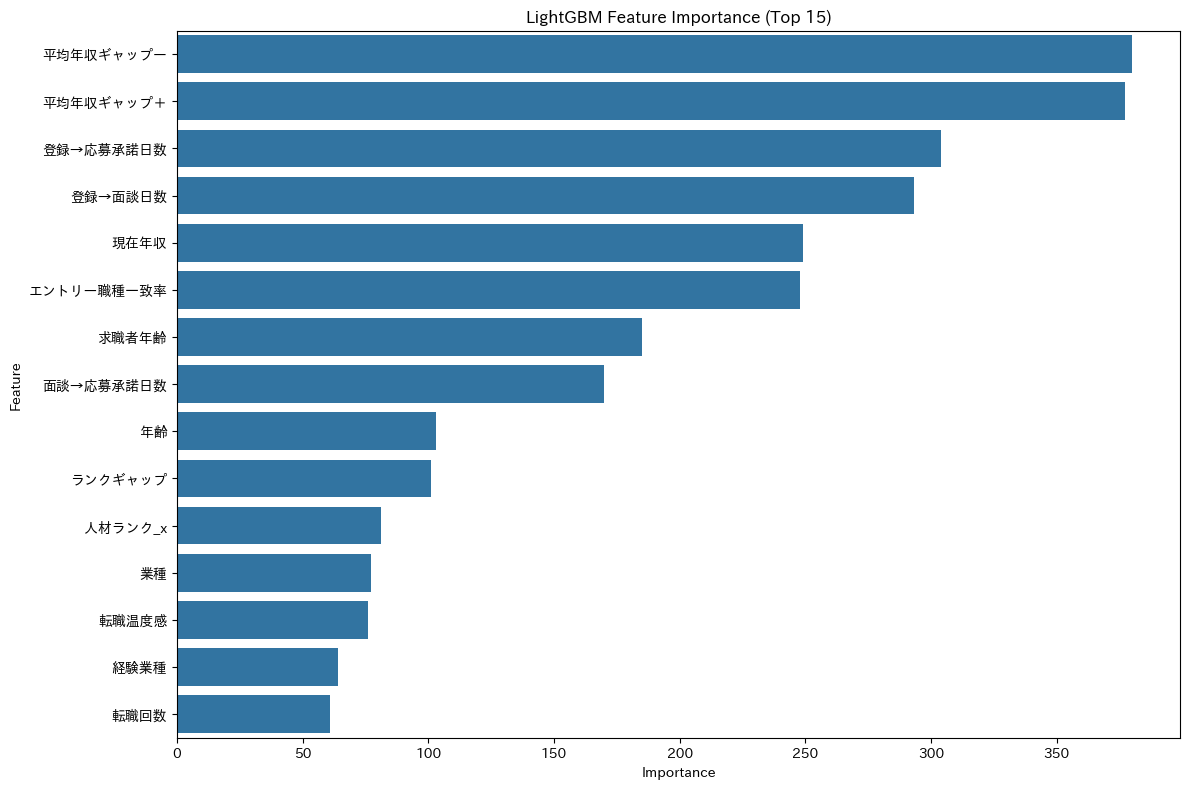

Top 15 Feature Importances:


Feature  Importance
21   平均年収ギャップー         380
20   平均年収ギャップ＋         377
27   登録→応募承諾日数         304
24     登録→面談日数         293
11        現在年収         249
19  エントリー職種一致率         248
5        求職者年齢         185
25   面談→応募承諾日数         170
14          年齢         103
23     ランクギャップ         101
0      人材ランク_x          81
2           業種          77
13       転職温度感          76
9         経験業種          64
10        転職回数          61

In [48]:

# Get feature importances from the trained LightGBM model
feature_importances = lgbm_model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top N most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('LightGBM Feature Importance (Top 15)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Top 15 Feature Importances:")
display(importance_df.head(15))

### SHAP

In [49]:
pip install shap

In [50]:
import shap

# Create a TreeExplainer using the trained LightGBM model
# X_train is used as the background dataset for the explainer
explainer = shap.TreeExplainer(lgbm_model)

# Calculate SHAP values for X_val
shap_values = explainer.shap_values(X_val)

print("SHAP values calculated successfully.")
# For binary classification, shap_values will be a list of arrays (one for each class).
# Printing the shape of the SHAP values for the positive class (index 1).
print("Shape of SHAP values for positive class:", np.array(shap_values[1]).shape)

SHAP values calculated successfully.
Shape of SHAP values for positive class: (29,)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


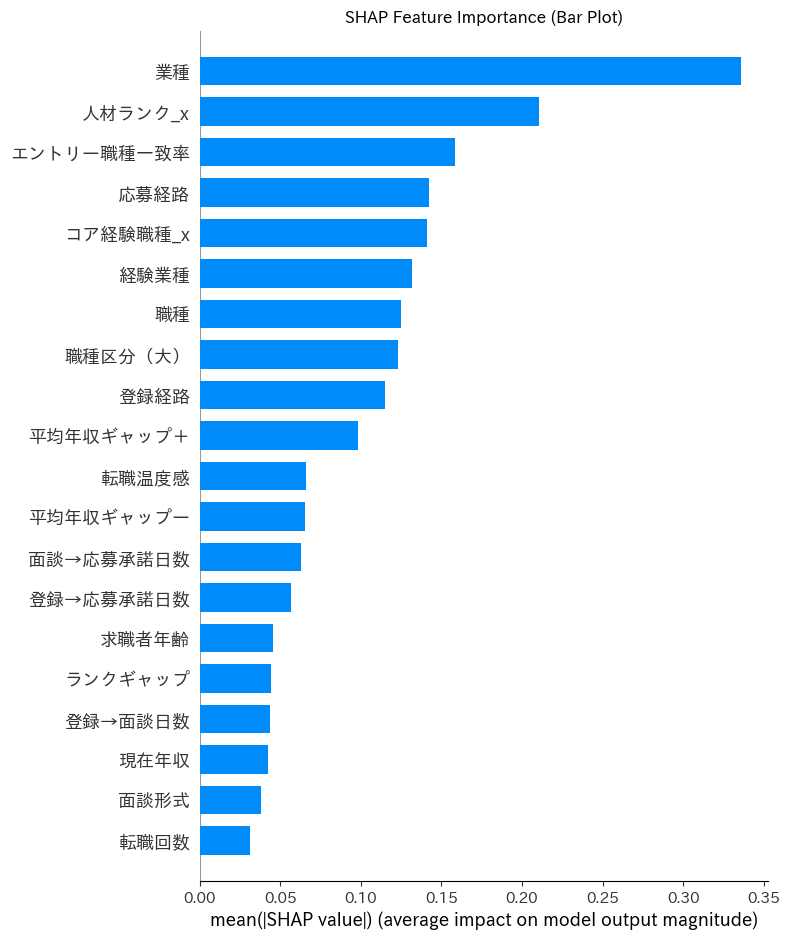

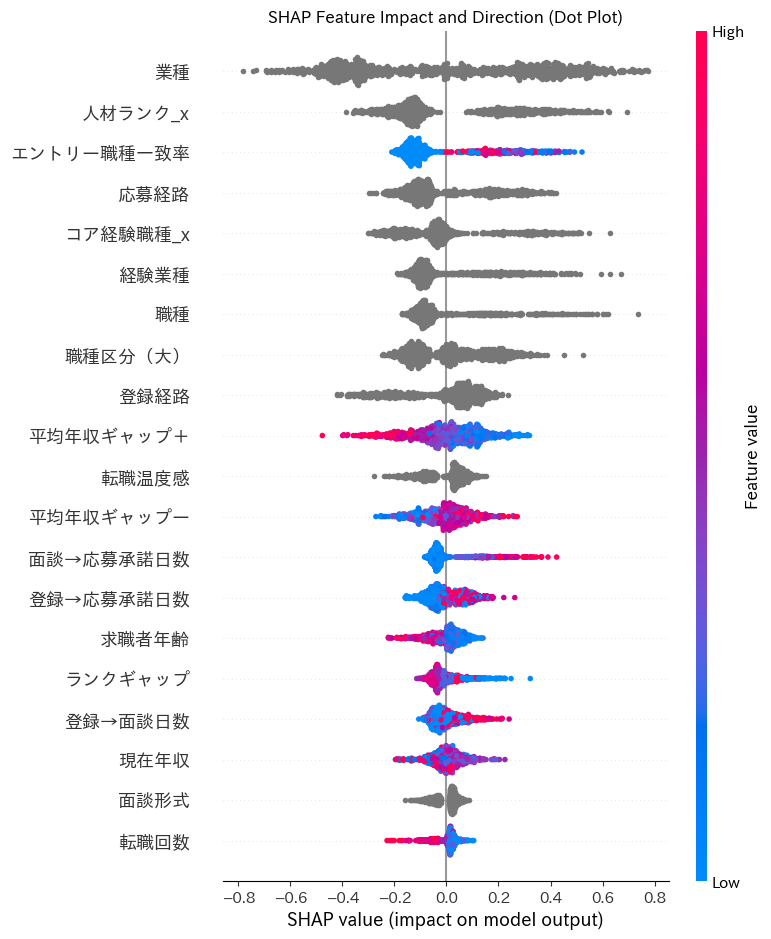

SHAP summary plots generated successfully.


In [51]:
import matplotlib.pyplot as plt

# Create a SHAP summary plot for the positive class (index 1)
# Pass shap_values directly, assuming it's already the matrix for the positive class
shap.summary_plot(shap_values, X_val, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar Plot)")
plt.tight_layout()
plt.show()

# Create a more detailed SHAP summary plot for the positive class (index 1)
# Pass shap_values directly, assuming it's already the matrix for the positive class
shap.summary_plot(shap_values, X_val, show=False)
plt.title("SHAP Feature Impact and Direction (Dot Plot)")
plt.tight_layout()
plt.show()

print("SHAP summary plots generated successfully.")

<Figure size 1000x600 with 0 Axes>

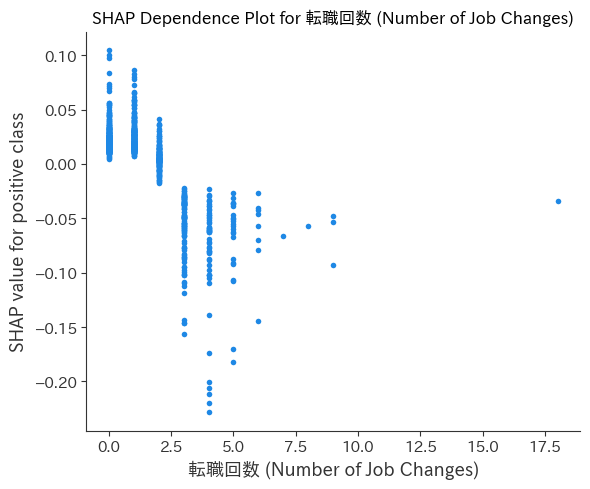

SHAP dependence plot for '転職回数' generated successfully.


In [52]:
import matplotlib.pyplot as plt

# Generate SHAP dependence plot for '転職回数'
plt.figure(figsize=(10, 6))
shap.dependence_plot('転職回数', shap_values, X_val, interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for 転職回数 (Number of Job Changes)')
plt.xlabel('転職回数 (Number of Job Changes)')
plt.ylabel('SHAP value for positive class')
plt.tight_layout()
plt.show()

print("SHAP dependence plot for '転職回数' generated successfully.")

<Figure size 1000x600 with 0 Axes>

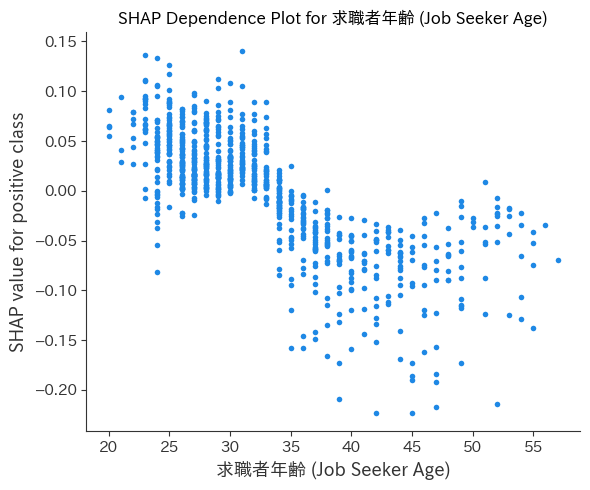

SHAP dependence plot for '求職者年齢' generated successfully.


In [53]:
import matplotlib.pyplot as plt

# Generate SHAP dependence plot for '求職者年齢'
plt.figure(figsize=(10, 6))
shap.dependence_plot('求職者年齢', shap_values, X_val, interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for 求職者年齢 (Job Seeker Age)')
plt.xlabel('求職者年齢 (Job Seeker Age)')
plt.ylabel('SHAP value for positive class')
plt.tight_layout()
plt.show()

print("SHAP dependence plot for '求職者年齢' generated successfully.")

<Figure size 1000x600 with 0 Axes>

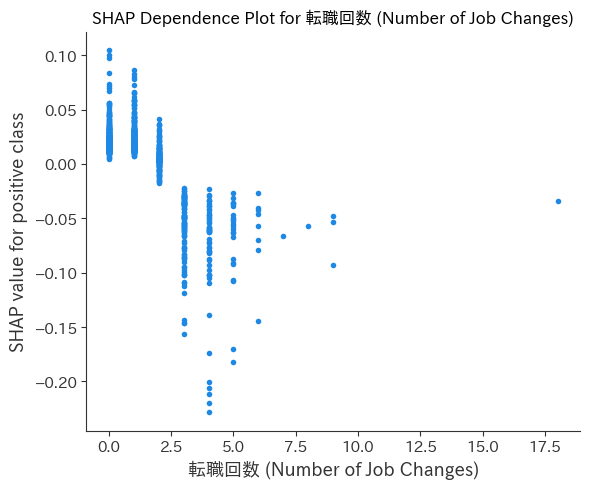

SHAP dependence plot for '転職回数' generated successfully.


In [54]:
import matplotlib.pyplot as plt

# Generate SHAP dependence plot for '転職回数'
plt.figure(figsize=(10, 6))
shap.dependence_plot('転職回数', shap_values, X_val, interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for 転職回数 (Number of Job Changes)')
plt.xlabel('転職回数 (Number of Job Changes)')
plt.ylabel('SHAP value for positive class')
plt.tight_layout()
plt.show()

print("SHAP dependence plot for '転職回数' generated successfully.")

<Figure size 1000x600 with 0 Axes>

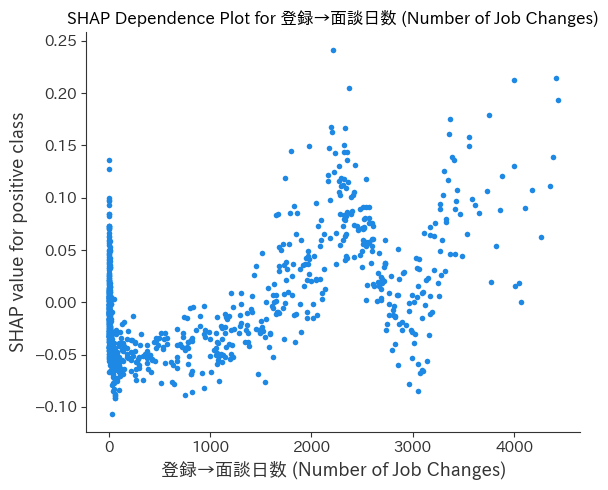

SHAP dependence plot for '登録→面談日数' generated successfully.


In [55]:
# Generate SHAP dependence plot for '登録→面談日数'
plt.figure(figsize=(10, 6))
shap.dependence_plot('登録→面談日数', shap_values, X_val, interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for 登録→面談日数 (Number of Job Changes)')
plt.xlabel('登録→面談日数 (Number of Job Changes)')
plt.ylabel('SHAP value for positive class')
plt.tight_layout()
plt.show()

print("SHAP dependence plot for '登録→面談日数' generated successfully.")

<Figure size 1000x600 with 0 Axes>

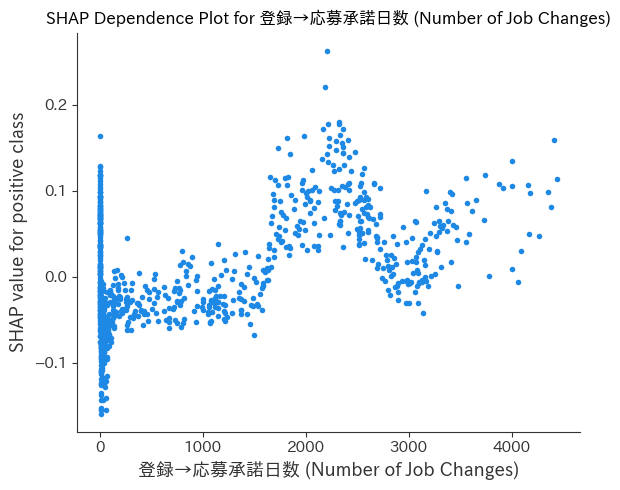

SHAP dependence plot for '登録→応募承諾日数' generated successfully.


In [56]:
# Generate SHAP dependence plot for '登録→応募日数'
plt.figure(figsize=(10, 6))
shap.dependence_plot('登録→応募承諾日数', shap_values, X_val, interaction_index=None, show=False)
plt.title('SHAP Dependence Plot for 登録→応募承諾日数 (Number of Job Changes)')
plt.xlabel('登録→応募承諾日数 (Number of Job Changes)')
plt.ylabel('SHAP value for positive class')
plt.tight_layout()
plt.show()

print("SHAP dependence plot for '登録→応募承諾日数' generated successfully.")